# TMDB Box Office Prediction

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, we're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

* Data Source: https://www.kaggle.com/c/tmdb-box-office-prediction/data

Total number of movies:7398
Number of Attributes/Columns in data: 23
Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

Attribute Information:
1. Id - unique identifier for the Movie
2. genres - categories determining the type of the film
3. original_language
4. original_title - title of the film
5. production_companies - directly responsible for fundraising for the production 
6. production_countries - countries involved in the production of the film
7. release_date  
8. runtime - the time in which the movie is telecasted 
9. status - determines whether the movie is released or rumoured
10. tagline - As a variant of a branding slogan, taglines can be used in marketing and advertising
11. keywords - the words mostly used in the film 
12. cast - group of actors who make up a film
13. crew - group of people, hired by a production company, for the purpose of producing a film 
14. revenue - total collections collected by the film


**Objective**

* Our job is  to predict the international box office revenue for each movie. For each id in the test set, you must predict the value of the revenue variable.The calculated revenue is evaluated based on the Root-Mean-Squared-Logarithmic-Error (RMSLE) between the predicted value and the actual revenue.

## Loading the data
The dataset is available as .csv file

In order to load the data, We have used the pandas as it easier to query the data and visualise the data efficiently. 

Here as we  want to get the revenue collected by the film, we will purposefully ignore the revenue coloumn in the test dataset which had been splitted from the available data.csv file.

We also need to import the libraries like scipy,nltk,sklearn,xgboost,lightgbm etc which required for the execution of our work


In [261]:
# Libraries

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [262]:
#spilt the data.csv into train and test datasets
data=pd.read_csv('data.csv')
data.head()
train=data.iloc[:2000,:]
test=data.iloc[2000:]

In [263]:
#looking at the number of attributes and size of the data
test.head(1)

id belongs_to_collection  budget  \
2000  2001                   NaN       0   

                                                 genres homepage    imdb_id  \
2000  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...      NaN  tt0078034   

     original_language    original_title  \
2000                en  The One and Only   

                                               overview  popularity  \
2000  1951: Andy Schmidt is in his last year of coll...     0.43491   

                           poster_path  \
2000  /ztvhOjbX6FJCBGZRzQvTq4cE4JV.jpg   

                                   production_companies  \
2000  [{'name': 'First Artists', 'id': 4376}, {'name...   

                                   production_countries release_date  runtime  \
2000  [{'iso_3166_1': 'US', 'name': 'United States o...       2/3/78     97.0   

                              spoken_languages    status  \
2000  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                                tagline             title  \
2000  She had to marry him. She was too embarrassed ...  The One and Only   

                                               Keywords  \
2000  [{'id': 6075, 'name': 'sport'}, {'id': 206441,...   

                                                   cast  \
2000  [{'cast_id': 3, 'character': 'Andy Schmidt', '...   

                                                   crew   revenue  
2000  [{'credit_id': '52fe474dc3a36847f812dfcf', 'de...  16928137

In [264]:
#dropping the revenue coloumn in the test file
test=test.drop(['revenue'], axis=1)

In [265]:
test.head(1)

id belongs_to_collection  budget  \
2000  2001                   NaN       0   

                                                 genres homepage    imdb_id  \
2000  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...      NaN  tt0078034   

     original_language    original_title  \
2000                en  The One and Only   

                                               overview  popularity  \
2000  1951: Andy Schmidt is in his last year of coll...     0.43491   

                           poster_path  \
2000  /ztvhOjbX6FJCBGZRzQvTq4cE4JV.jpg   

                                   production_companies  \
2000  [{'name': 'First Artists', 'id': 4376}, {'name...   

                                   production_countries release_date  runtime  \
2000  [{'iso_3166_1': 'US', 'name': 'United States o...       2/3/78     97.0   

                              spoken_languages    status  \
2000  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                                tagline             title  \
2000  She had to marry him. She was too embarrassed ...  The One and Only   

                                               Keywords  \
2000  [{'id': 6075, 'name': 'sport'}, {'id': 206441,...   

                                                   cast  \
2000  [{'cast_id': 3, 'character': 'Andy Schmidt', '...   

                                                   crew  
2000  [{'credit_id': '52fe474dc3a36847f812dfcf', 'de...

In [136]:
#convert the pandas file into a .csv file
test.to_csv("test.csv", index=False)

In [137]:
train.to_csv("train.csv", index=False)

In [138]:
#load the train and test datasets into the model
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

<a id="data_loading"></a>
## Data loading and overview

In [139]:
#train = pd.read_csv(df1_train)
#test = pd.read_csv(df2_test)

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

In [140]:
train.shape, test.shape

((2000, 23), (1000, 22))

There are only 2000 samples in train data! Let's hope this is enough to train models.

We can see that some of columns contain lists with dictionaries. Some lists contain a single dictionary, some have several. Let's extract data from these columns!

<a id="btoc"></a>
### belongs_to_collection

In [141]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [142]:
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    1596
1     404
Name: belongs_to_collection, dtype: int64

1596 values in this column are empty, 404 contain information about the collections. I suppose that only collection name can be useful. Another possibly useful feature is the fact of belonging to a collection.

In [143]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

<a id="genres"></a>
### genres

In [144]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [145]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    649
3    592
1    402
4    258
5     78
6     15
0      4
7      2
Name: genres, dtype: int64

Genres column contains named and ids of genres to which films belong. Most of films have 2-3 genres and 5-6 genres are possible. 0 and 7 are outliers, I think. Let's extract genres! I'll create a column with all genres in the film and also separate columns for each genre.

But at first let's have a look at the genres themselves.

In [146]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

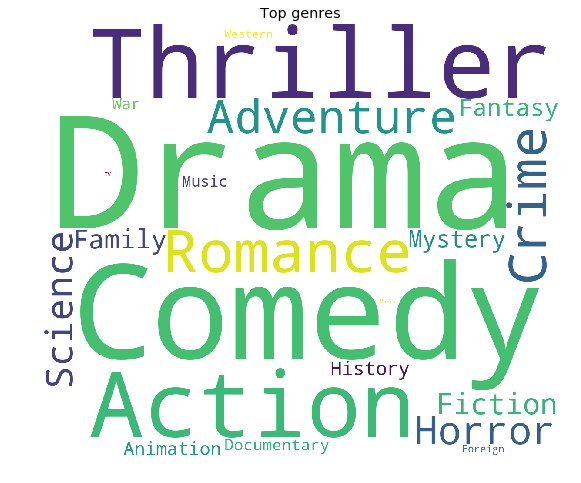

In [147]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

Drama, Comedy and Thriller are popular genres.

In [148]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1009),
 ('Comedy', 674),
 ('Thriller', 545),
 ('Action', 477),
 ('Romance', 386),
 ('Crime', 299),
 ('Adventure', 294),
 ('Horror', 207),
 ('Science Fiction', 187),
 ('Family', 178),
 ('Fantasy', 156),
 ('Mystery', 150),
 ('History', 96),
 ('Animation', 89),
 ('War', 69),
 ('Documentary', 67),
 ('Music', 65),
 ('Western', 30),
 ('Foreign', 23),
 ('TV Movie', 1)]

I'll create separate columns for top-15 genres.

In [149]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

<a id="production_companies"></a>
### production_companies

In [150]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [151]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     530
2     473
3     382
4     201
0     114
5     106
6      88
7      44
8      23
9      21
11      6
10      5
12      2
16      2
15      1
13      1
14      1
Name: production_companies, dtype: int64

Most of films have 1-2 production companies, sometimes 3-4. But there are films with 10+ companies! Let's have a look at some of them.

In [152]:
train[train['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 11]

id    budget                                homepage    imdb_id  \
31      32         0             http://www.cache-derfilm.at  tt0387898   
116    117         0                                     NaN  tt2113822   
363    364  15400000                                     NaN  tt2053425   
392    393         0                                     NaN  tt5072406   
449    450  80000000  http://asoundofthunder.warnerbros.com/  tt0318081   
554    555  14500000                                     NaN  tt0293416   
1079  1080   7000000                                     NaN  tt2737050   

     original_language        original_title  \
31                  fr                 Caché   
116                 zh                  一九四二   
363                 fr    De rouille et d'os   
392                 fr                  Moka   
449                 en    A Sound of Thunder   
554                 ja            Metropolis   
1079                fr  Deux jours, une nuit   

                                               overview  popularity  \
31    A married couple is terrorized by a series of ...    5.695860   
116   In 1942, Henan Province was devastated by the ...    1.678013   
363   Put in charge of his young son, Ali leaves Bel...    8.400049   
392   Diane Kramer is led by one obsession: to find ...    2.404466   
449   When a hunter sent back to the prehistoric era...    4.980191   
554   Duke Red has overseen the construction of a ma...    9.298092   
1079  Sandra is a young woman who has only one weeke...    6.868022   

                           poster_path  \
31    /i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg   
116    /xxz2gi8vijqqJySGO3kQy2i8mv.jpg   
363   /cHCwW8xPl8yPKQwpNzKVinwvirT.jpg   
392   /5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg   
449   /gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg   
554   /1EK7mGCpRKYmSg25FaojvnS9opm.jpg   
1079  /1mYAejpMskvskGr0J0SaBvdjmrH.jpg   

                                   production_companies  \
31    [{'name': 'Les Films du Losange', 'id': 223}, ...   
116   [{'name': 'Emperor Motion Pictures', 'id': 272...   
363   [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
392   [{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...   
449   [{'name': 'Epsilon Motion Pictures', 'id': 117...   
554   [{'name': 'Bandai Visual Company', 'id': 528},...   
1079  [{'name': 'BIM Distribuzione', 'id': 225}, {'n...   

                                   production_countries release_date  runtime  \
31    [{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...       5/2/05    117.0   
116             [{'iso_3166_1': 'CN', 'name': 'China'}]      11/1/12    145.0   
363   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      5/17/12    123.0   
392   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      8/17/16     89.0   
449   [{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...      5/15/05    110.0   
554             [{'iso_3166_1': 'JP', 'name': 'Japan'}]      5/26/01    108.0   
1079  [{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...      5/21/14     95.0   

                                       spoken_languages    status  \
31            [{'iso_639_1': 'fr', 'name': 'Français'}]  Released   
116   [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
363   [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
392           [{'iso_639_1': 'fr', 'name': 'Français'}]  Released   
449   [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
554   [{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...  Released   
1079          [{'iso_639_1': 'fr', 'name': 'Français'}]  Released   

                                 tagline                title  \
31                                   NaN                Caché   
116                                  NaN         Back to 1942   
363                                  NaN        Rust and Bone   
392                                  NaN                 Moka   
449   Some Rules Should Never Be Broken.   A Sound of Thunder   
554                Welcome to Metropolis           

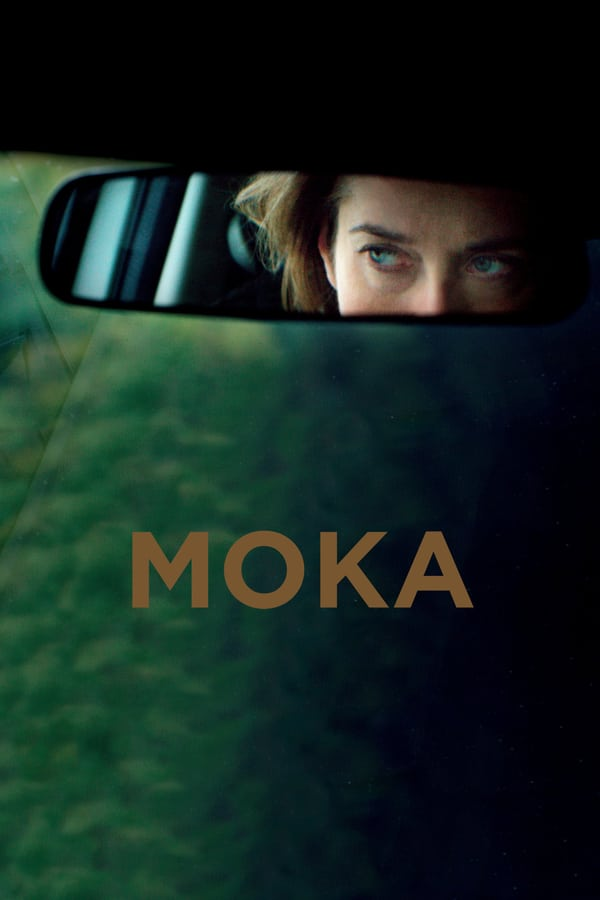

In [153]:
# example poster of such a film

img = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg"))
img

In [154]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [155]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Universal Pictures', 137),
 ('Warner Bros.', 135),
 ('Paramount Pictures', 103),
 ('Twentieth Century Fox Film Corporation', 91),
 ('Columbia Pictures', 58),
 ('Metro-Goldwyn-Mayer (MGM)', 50),
 ('New Line Cinema', 47),
 ('Columbia Pictures Corporation', 45),
 ('Touchstone Pictures', 44),
 ('Walt Disney Pictures', 41),
 ('United Artists', 31),
 ('TriStar Pictures', 31),
 ('Canal+', 30),
 ('Relativity Media', 29),
 ('Miramax Films', 24),
 ('StudioCanal', 23),
 ('Dune Entertainment', 22),
 ('Working Title Films', 22),
 ('BBC Films', 20),
 ('Fox Searchlight Pictures', 19),
 ('Regency Enterprises', 18),
 ('Village Roadshow Pictures', 18),
 ('Lionsgate', 18),
 ('Fox 2000 Pictures', 18),
 ('DreamWorks SKG', 17),
 ('Summit Entertainment', 16),
 ('Hollywood Pictures', 16),
 ('Orion Pictures', 16),
 ('Epsilon Motion Pictures', 15),
 ('Legendary Pictures', 15)]

For now I'm not sure what to do with this data. I'll simply create binary columns for top-30 films. Maybe later I'll have a better idea.

In [156]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

<a id="production_countries"></a>
### production_countries

In [157]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [158]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    1468
2     360
3      84
4      36
0      36
5      13
6       2
8       1
Name: production_countries, dtype: int64

Normally films are produced by a single country, but there are cases when companies from several countries worked together.

In [159]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 1517),
 ('United Kingdom', 258),
 ('France', 152),
 ('Germany', 104),
 ('Canada', 79),
 ('India', 49),
 ('Italy', 47),
 ('Japan', 43),
 ('Australia', 43),
 ('Spain', 40),
 ('Russia', 39),
 ('China', 26),
 ('Hong Kong', 24),
 ('South Korea', 16),
 ('Ireland', 16),
 ('Belgium', 16),
 ('Mexico', 15),
 ('Sweden', 13),
 ('Netherlands', 11),
 ('New Zealand', 10),
 ('Czech Republic', 10),
 ('Denmark', 10),
 ('Brazil', 9),
 ('South Africa', 8),
 ('Austria', 7)]

In [160]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

<a id="lang"></a>
### Spoken languages

In [161]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [162]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    1394
2     363
3     156
4      46
0      16
5      15
6       5
7       3
8       2
Name: spoken_languages, dtype: int64

In [163]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 1749),
 ('Français', 189),
 ('Español', 165),
 ('Deutsch', 109),
 ('Pусский', 107),
 ('Italiano', 88),
 ('日本語', 59),
 ('普通话', 47),
 ('हिन्दी', 36),
 ('العربية', 29),
 ('Português', 28),
 ('', 28),
 ('한국어/조선말', 22),
 ('广州话 / 廣州話', 22),
 ('தமிழ்', 19)]

In [164]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

<a id="keywords"></a>
### Keywords

In [165]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [166]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    187
0    181
4    172
3    150
2    146
6    140
1    125
7    116
8    114
9     91
Name: Keywords, dtype: int64

Here we have some keywords describing films. Of course there can be a lot of them. Let's have a look at the most common ones.

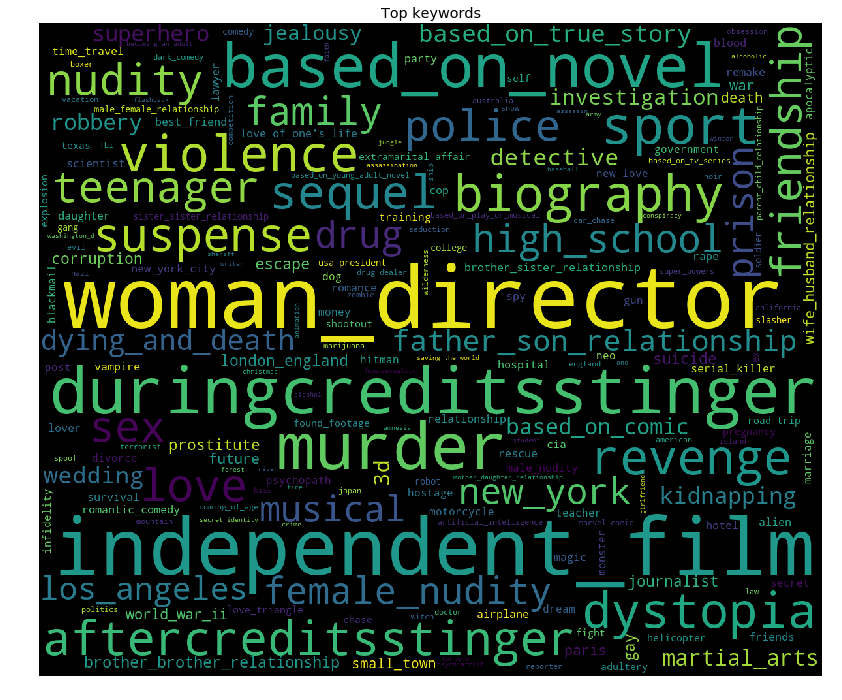

In [167]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [168]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

<a id="cast"></a>
### cast

In [169]:
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [170]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    131
16     99
11     91
13     90
10     90
18     78
9      78
8      76
17     75
14     74
Name: cast, dtype: int64

Those who are casted heavily impact the quality of the film. We have not only the name of the actor, but also the gender and character name/type.

At first let's have a look at the popular names.

In [171]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 19),
 ('Liam Neeson', 19),
 ('Bruce McGill', 19),
 ('Robert De Niro', 18),
 ('J.K. Simmons', 17),
 ('Sylvester Stallone', 17),
 ('Michael Caine', 16),
 ('Robert Downey Jr.', 16),
 ('Dennis Quaid', 16),
 ('John Turturro', 16),
 ('Jason Statham', 15),
 ('Keith David', 15),
 ('Forest Whitaker', 15),
 ('Robert Duvall', 15),
 ('Mel Gibson', 15)]

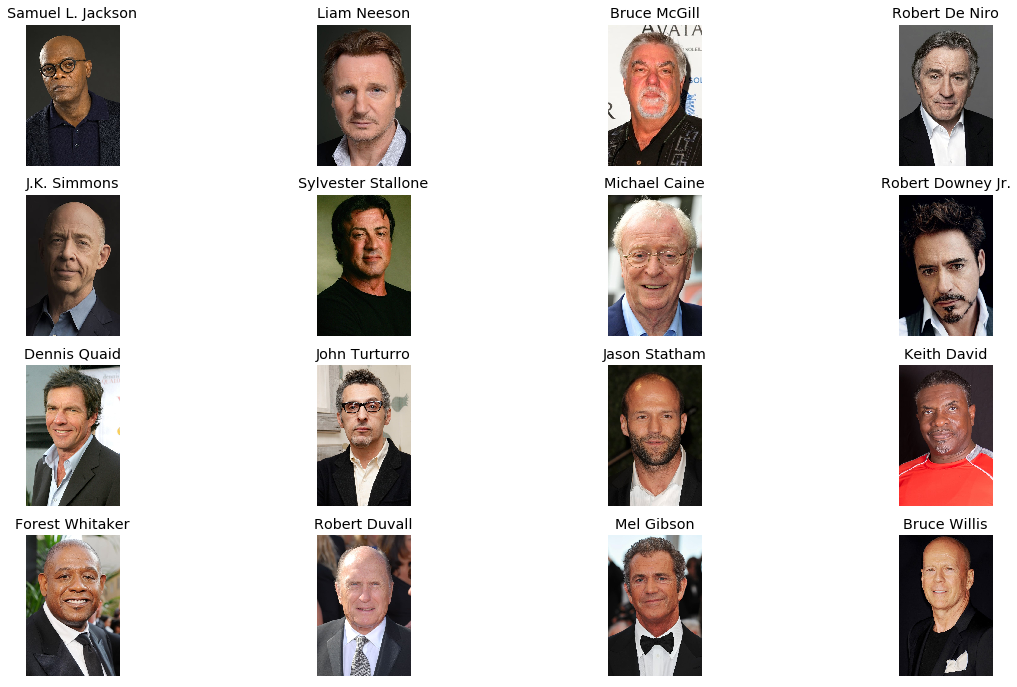

In [172]:
list_of_cast_names_url = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    plt.imshow(im)
    ax.set_title(f'{p[0]}')

In [173]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 18192), (0, 13738), (1, 8803)]

0 is unspecified, 1 is female, and 2 is male. (https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/80983#475572)

In [174]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 594),
 ('Himself', 415),
 ('Herself', 89),
 ('Dancer', 85),
 ('Additional Voices (voice)', 73),
 ('Doctor', 54),
 ('Debutante', 50),
 ('Waitress', 43),
 ('Nurse', 42),
 ('Reporter', 39),
 ('Bartender', 36),
 ('Security Guard', 35),
 ('Jack', 34),
 ('Paul', 31),
 ('Mary', 30)]

I think it is quite funny the most popular male role is playing himself. :)

In [175]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

<a id="crew"></a>
### crew

In [176]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [177]:
print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


2     130
3      85
11     82
10     79
8      78
9      75
12     75
4      70
7      67
14     65
Name: crew, dtype: int64

The great crew is very important in creating the film. We have not only the names of the crew members, but also the genders, jobs and departments.

At first let's have a look at the popular names.

In [178]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 32),
 ('Luc Besson', 29),
 ('James Newton Howard', 26),
 ('Jerry Goldsmith', 26),
 ('Francine Maisler', 24),
 ('Kerry Barden', 23),
 ('Steven Spielberg', 22),
 ('John Papsidera', 22),
 ('Hans Bjerno', 21),
 ('Mary Vernieu', 21),
 ('Bob Weinstein', 20),
 ('John Debney', 19),
 ('Sylvester Stallone', 19),
 ('Roger Birnbaum', 19),
 ('Harvey Weinstein', 19)]

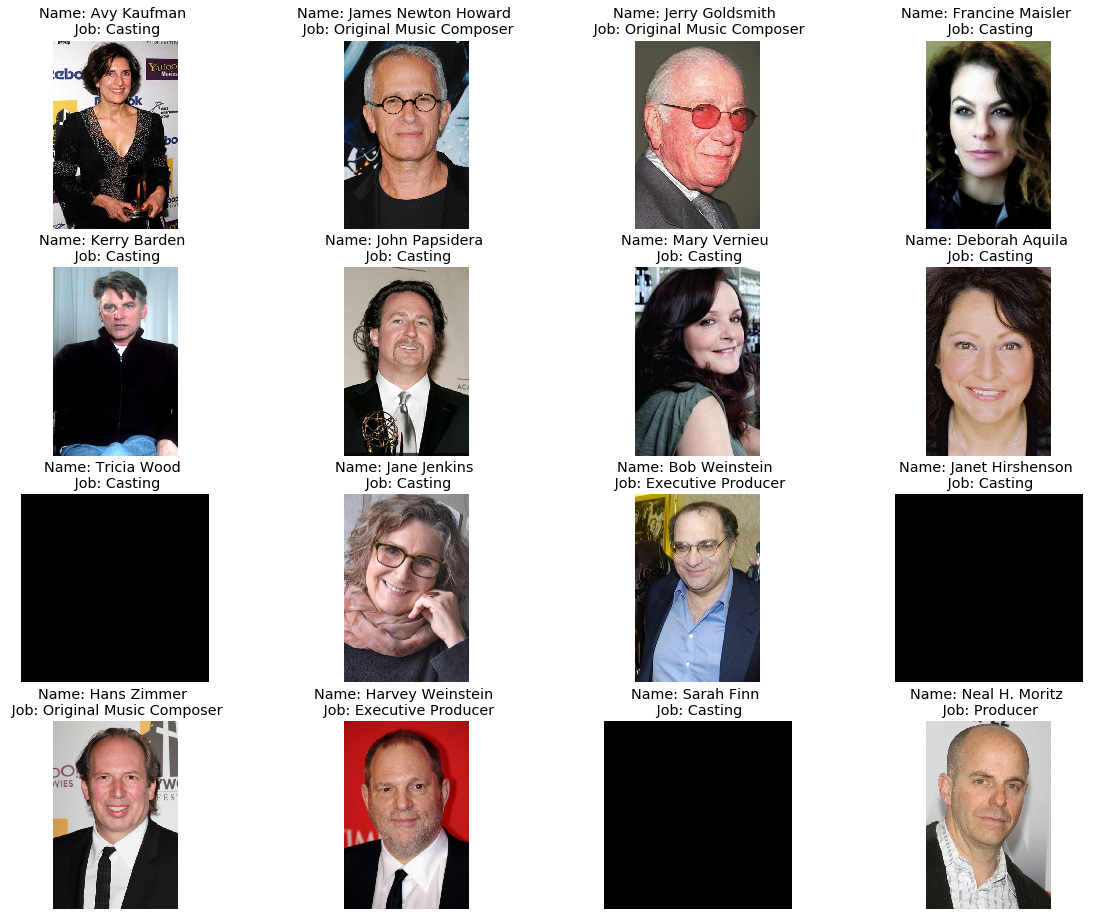

In [179]:
list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_crew_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 16))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    if p[1]:
        im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    else:
        im = Image.new('RGB', (5, 5))
    plt.imshow(im)
    ax.set_title(f'Name: {p[0]} \n Job: {p[2]}')

In [180]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 3969),
 ('Executive Producer', 2249),
 ('Director', 2157),
 ('Screenplay', 1989),
 ('Editor', 1848),
 ('Casting', 1614),
 ('Director of Photography', 1497),
 ('Original Music Composer', 1265),
 ('Art Direction', 1209),
 ('Production Design', 1093),
 ('Costume Design', 1047),
 ('Writer', 1034),
 ('Set Decoration', 895),
 ('Makeup Artist', 773),
 ('Sound Re-Recording Mixer', 633)]

In [181]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 27728), (2, 16220), (1, 4214)]

In [182]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 10398),
 ('Sound', 6012),
 ('Art', 5371),
 ('Crew', 4803),
 ('Writing', 4371),
 ('Costume & Make-Up', 4163),
 ('Camera', 3576),
 ('Directing', 3295),
 ('Editing', 2972),
 ('Visual Effects', 2336),
 ('Lighting', 861),
 ('Actors', 4)]

In [183]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 32),
 ('Luc Besson', 29),
 ('James Newton Howard', 26),
 ('Jerry Goldsmith', 26),
 ('Francine Maisler', 24),
 ('Kerry Barden', 23),
 ('Steven Spielberg', 22),
 ('John Papsidera', 22),
 ('Hans Bjerno', 21),
 ('Mary Vernieu', 21),
 ('Bob Weinstein', 20),
 ('John Debney', 19),
 ('Sylvester Stallone', 19),
 ('Roger Birnbaum', 19),
 ('Harvey Weinstein', 19)]

In [184]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

<a id="de"></a>
## Data exploration

In [185]:
#looking at the number of attributes and size of the data
train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title   revenue  \
0                    Hot Tub Time Machine 2  12314651   
1  The Princess Diaries 2: Royal Engagement  95149435   
2                                  Whiplash  13092000   
3                                   Kahaani  16000000   
4                                Marine Boy   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0              1            0                0             0   
2             0              0            0                0             0   
3             0              0            0                0             0   
4             1              0            0                0             0   

   genre_Science Fiction  genre_Family  genre_Fantasy  genre_Mystery  \
0                      0             0              0              0   
1                      0             1              0              0   
2                      0             0              0              0   
3                      0             0              0              0   
4               

<a id="target"></a>
### Target

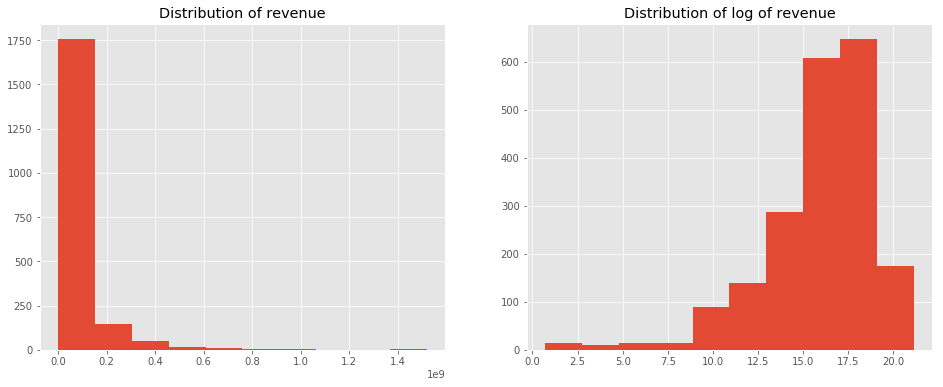

In [186]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

In [187]:
train['log_revenue'] = np.log1p(train['revenue'])

As we can see revenue distribution has a high skewness! It is better to use `np.log1p` of revenue.

<a id="budget"></a>
### Budget

In [188]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA68AAAGDCAYAAADEaSaNAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3X9c1fXd//HniRMgIAjniA7MFH8sJUwTlayE8Fxt09aodnldU9vMmUs2HbqZzvY125axmcFIXS2Nfti1Xa3LWLNmu04IrB/WIcDfJU5rtVSEgyhQKfD5/uGtc3kCBOHI+Rx83G+33W6d93mfz+f1fst48zyf9/kci2EYhgAAAAAAMLHL/F0AAAAAAAAdIbwCAAAAAEyP8AoAAAAAMD3CKwAAAADA9AivAAAAAADTI7wCAAAAAEyP8IqAtWrVKg0fPvyiHLuoqEgWi0Uff/xxm4997amnnpLVar0ox+6Kjz76SFOnTlV4eLgsFkubfS52zRaLRZs3b75oxweASxlr6MXTmTX0Ys/JhTp58qRuu+02RUZGymKx6IMPPmjV52LXPGTIEP3qV7+6KMdG70F4hanMmTNHFotFFotFVqtVMTExuu666/TAAw/I7XZ79f3pT3+qHTt2dPrYw4cP16pVqzrVd/LkyTpy5Iji4uIupPwOffzxx7JYLCoqKvJq/4//+A/961//8um5umP16tWqqqpSRUWFjhw54u9yfKa9+QeA3oA11BwCcQ393e9+p7feektvvPGGjhw5oiuuuMLfJfmM1WrVU0895e8y4COEV5jOjTfeqCNHjuif//yn/v73v+vuu+/WH/7wByUmJurAgQOefhEREbLb7T4//+nTpxUcHKyBAwfqsst65v8iffr00YABA3rkXJ1RWVmpiRMnasSIERo4cKC/ywEAdBJrqP8F4hpaWVmpxMREJSUlaeDAgQoKCvJ3SUCbCK8wnS8Wvbi4OCUmJmru3Ll65513FBYWpnvuucfT78tbnj7++GPdcccdstvt6tOnjxISErRmzRpJUlpamv7xj3/ogQce8Lwr/cEHH3i2wLz88su64YYbFBoaqt///vftbo0pLy/XxIkTFRoaqsTERP3v//6v57n2XnPuO35fvJN50003yWKxaMiQIZLa3vL0yiuvaPz48QoJCVFsbKwyMzPV0NDgeX7OnDlyOBz6/e9/ryuvvFKRkZH61re+pePHj593fk+dOqUf/OAH6t+/v0JDQ5WcnKy//e1vnuctFotee+01Pfnkk7JYLJozZ855j+d0OpWYmKjQ0FBNnDhRZWVlnufaGldb75xv375dY8aMUWhoqMaMGaPt27e3Ok95eblSUlIUGhqqkSNH6oUXXmi1xai+vl4//vGPFR8fr7CwMI0bN05btmzxPN/e/ANAb8EaelagrKHn2rFjh6ZMmaI+ffooOjpaM2fOVFVVlVef3NxcDRo0SGFhYfra176mZ599tsOtvGfOnNHy5csVHx+v4OBgjR49Wv/1X//leX7IkCHatGmTCgsLZbFYlJaWdt46u/vvKEk7d+7U5MmTPWv6888/3+o8hw8f1s0336zQ0FANHjxY69evV1pamubNm+fp09TUpFWrVmno0KGeeh5//HGvsTU3N+uuu+7y/OwisBFeERAiIyO1YMECFRUVtbuwZGZmqq6uTk6nU/v379emTZs0aNAgSdKWLVs0ZMgQ/eQnP9GRI0dabYn5yU9+onvvvVf79+9XRkZGu3UsWbJEK1eu9ASpW2+99YK2Kn0R7P7nf/5HR44ckcvlarPfrl27dOutt2rKlCmqqKjQ008/ra1bt3r94SFJLpdL27dv18svv6xt27apoqJCP/3pT89bw9y5c/Xqq69q8+bNKi8v1/XXX69bbrlF7733niTpyJEjuu666zRz5kwdOXJEv/3tb9s9VktLi+69915t2LBB77zzjmJjYzV9+nQ1NjZ2ek4++eQT3XLLLRo/frzKysq0du1a/fjHP/bq09jYqGnTpql///5655139Mwzz+iRRx7xWtQNw9A3v/lN7dy5U//93/+tPXv2aMGCBfrP//xPvfbaa5I6P/8A0JuwhppzDT3X0aNHdfPNN2vQoEF655139Je//EV79uzRHXfc4emzZcsW/fSnP9XSpUu1c+dOfec739GyZcs6PPaKFSv0xBNPKDc3V3v27NHs2bM1e/Zsz9rocrk0Y8YMz1X7c9/0bUt3/x0//fRTTZs2Tf369dPbb7+tp59+WmvWrGm1pt92222qq6tTSUmJXnrpJb388ssqLy/3Ota8efO0ZcsWPf7449q/f79WrlypZcuWadOmTZ6xBQUFKTc31/OziwBnACbyve99z5g6dWqbz/31r381JBlvv/22YRiGcf/99xvDhg3zPD9mzBjj/vvvb/fYw4YNa/X89u3bDUnGM88802b7Rx995PV448aNnj5nzpwxBg8ebNx3331tvuYLQUFBRn5+vmEYhvHRRx8Zkozt27d79cnPzzeCgoI8j2fPnm1MmDDBq09BQYFhsViMDz74wDCMs3Nlt9uNzz77zNPnoYceMgYOHNjuHFRWVhqSjJdfftmrfdy4ccZdd93leZyammp8//vfb/c4X9QsyXA6nZ42t9tthIeHG0888USb4zKM1nNw3333GYMHDzbOnDnj6fOXv/zFkGQ8++yzhmEYxu9//3sjPDzcOHHihKfP/v37DUnGL3/5S8Mwzs5/SEiIVx/DMIy77rrL+Na3vtXmuQGgN2ENPSsQ1tAvj/fnP/+5ER8fb3z++eeePhUVFYYko7i42DAMw5g8ebIxe/Zsr+MsW7aszXn7QkNDgxEcHGysX7/eqz0jI8O46aabPI/P97Pz5Zq7++/4xBNPGOHh4Ybb7fY8v3v3bq81/W9/+5shyaisrPT0qampMfr06eOZ20OHDhkWi8XYv3+/17keeOAB45prrmnz3Ah8XHlFwDAMQ5La3fKRlZWl1atXa9KkSVq2bJlKSko6feyJEyd2qt91113n+W+r1aqJEydq3759nT5PZ+3du1dTpkzxaktNTZVhGF7nGzVqlEJCQjyP4+PjdezYsXaP+8Vrv3zsKVOmaO/evV2q9dw5iY6O1qhRoy5oTvbt26eJEyd6bfm64YYbWvUZNWqUoqKiPG1XXXWV+vXr53nscrl0+vRpxcfHKyIiwvO/zZs3q7KysitDA4BegzXUnGvouTWnpKQoODjY03bNNdcoKirKc+x9+/YpJSXF63XnzmlbDh48qNOnT7c5H75Y97vy7/jFmh4dHe1pu/rqq73W+H379slut3ttbY+JidFXv/pVz+PS0lIZhqHk5GSvdX/16tWs+72Yee4rDnRgz549slgsSkhIaPP5u+66S1//+te1bds2bd++Xd/4xjd02223derrVsLDw7tU0xd/DEjy3Jji3Lbm5ma1tLR06djt/YFxbvu5i9wXz517/s4yDMNnnwNpa07OdebMmQ7P3VYtHdXX0tKiqKioNreRfXmeAOBSwxraut1sa2hnau7qeb78uou97p/v37Gz5+7Mui9Jb775psLCwi7otQhcXHlFQDh58qR+97vfaerUqbLZbO32+8pXvqK77rpLzzzzjDZt2qTnnntOJ0+elHR2kWpubu5WHed+rUBTU5NcLpdGjRolSYqNjZV09jOcX6ioqPD6Bf7FQtlRHYmJiSouLvZqKy4ulsVi0ejRo7tcf2JioiS1ekf973//u+e5C3XunJw4cULvvfee15w0Nzd7vZN97g2dvqjp7bff9pqT119/3avP6NGjtX//ftXV1Xna3n//fZ04ccLzODk5WSdOnNBnn32m4cOHe/1v8ODBkjo//wDQm7CGmncNPffYb731lk6fPu1p27lzp+rq6jzHHj16tN566y2v13X0dUfDhw9XSEhIq/koKSnxybrflX/HxMRE7du3z2sN37t3r9caP3r0aB0/flwHDx70tNXW1nrdMXv8+PGSpH/+85+t1v1hw4Z5+vniZxfmQXiF6Zw+fVpHjx7VkSNHtG/fPj355JOaOHGiPv/8c/3ud79r93U/+tGP9Morr+gf//iH9u7dqy1btuiKK65Q3759JUlDhw7VG2+8oX/+85+qrq7u0ru52dnZeuWVV7R//34tWLBAx44d04IFCySdXSCuvPJKrVq1Su+9955ef/11LV682OvdP7vdroiICP3tb3/T0aNHVVtb2+Z5li5dqrKyMi1ZskTvvfeetm3bpoULF2rWrFmeINYVw4YN07//+78rMzNTr776qt577z39+Mc/1p49e7R06dILPp7FYtG9996rkpIS7d69W9/97ncVHh6umTNnSjq7laxv375avny5KisrtW3bNv3iF7/wOsaCBQt0/PhxzZ8/X/v379drr72m++67z6vPrFmzFBERoe9+97vatWuX3n77bX3/+99Xnz59PPObnp4uh8Oh22+/XS+++KIOHTqkd999V48++qieeOIJSZ2ffwAIVKyhgbOGnutHP/qRTp48qTlz5mjPnj16/fXXdeedd+qGG27QjTfeKOnsjbH++Mc/6tFHH9XBgwf1zDPP6JlnnpHU/pXGsLAwLVq0SP/v//0//elPf1JlZaVWr16tP//5z1qxYkWXau3uv+PMmTPVt29fzZ49Wzt37tSOHTs0d+5c9enTx9PH4XDommuu0Xe/+125XC7t3LlTd955p6xWq+dYw4cP19y5c3X33Xfr2Wef1cGDB7Vz5049+eST+vWvf+051tChQ7V9+3Z98sknqq6u7tKYYSI9+QFboCPf+973DEmGJCMoKMjo16+fMWnSJOOBBx7w+mC/YbS+2URmZqYxYsQIIzQ01IiJiTGmTZtm7Nmzx/O8y+Uyrr32WiM0NNSQZBw+fLjdGwu0d7OJP//5z8a1115rBAcHG6NGjTK2bdvm9bodO3Z4zjFmzBijpKSk1Y0Cnn76aWPIkCGG1Wo1rrzySsMw2r6x0csvv+w5l91uN+655x6jvr7ea66+fHOFZ5991ujo/9Z1dXXG/PnzDbvdbgQHBxvjx483Xn31Va8+nb1hU1BQkPHqq68aV111lREcHGwkJycbLpfLq9/WrVuNq666yggNDTUmT55sbNu2rdUNN5xOp3H11VcbwcHBRmJiovHaa6953bDJMAyjrKzMmDRpkhEcHGwMHz7c+NOf/mT079/fePjhhz19GhsbjWXLlhlDhgwxLr/8cmPAgAHG1772NeO1117z9Glr/gGgN2AN/T9mX0Pbmru33nrLuPHGG43Q0FAjKirK+M53vmMcO3bM63WPPPKIERcXZ4SGhho333yz8fjjjxuSjOrq6nbPdfr0aWPZsmVGXFyccfnllxujRo0ynnvuOa8+F3LDJl/8O5aVlRkpKSlGcHCwkZCQYPzhD38wrrzySs8Nmwzj7A2ZHA6HERISYgwaNMhYt26dMWHCBONHP/qRp09TU5Px61//2vjqV79qXH755YbNZjOmTJliPP/8854+f/3rXz1/pxB9Ap/FMLqwuR8A/OzDDz/UkCFD9NJLL+mb3/ymv8sBAKDH/eIXv9Bvf/tb1dTU+LuUi+7UqVMaNGiQfvWrX2nhwoX+Lgd+wg2bAASEzZs3Kz4+XkOHDtWHH36oe++9V1deeaVuvvlmf5cGAMBFd+bMGa1du1bTpk1TeHi4tm/frjVr1uiHP/yhv0u7KF566SVZrVaNGjVKVVVVeuCBB2SxWDRjxgx/lwY/IrwCCAg1NTW6//779a9//UsxMTG6/vrr9ac//cnraw4AAOitLBaLioqKtHbtWp06dUpDhw7VihUruv15W7NqbGzUL37xC33wwQcKDw/X+PHj9frrr2vAgAH+Lg1+xLZhAAAAAIDpcbdhAAAAAIDpEV4BAAAAAKZHeAUAAAAAmJ7pb9j0ySef+OQ4drudLyY+B/PRGnPijfnwxnx4C9T5iIuL83cJvQJrc2DXLgV2/YFcuxTY9Qdy7VJg1x/ItUvnr/9C1mauvAIAAAAATI/wCgAAAAAwPcIrAAAAAMD0CK8AAAAAANMjvAIAAAAATI/wCgAAAAAwPcIrAAAAAMD0CK8AAAAAANMjvAIAAAAATI/wCgAAAAAwPcIrAAAAAMD0CK8AAAAAANOz+rsAAADgG5988olycnI8j6uqqjRjxgylpqYqJydHx48fV//+/bV48WJFRETIMAzl5+ervLxcISEhyszMVEJCgh9HAABA+y6Z8Hrstsn+LqGVoCde8ncJAIBeJC4uTmvWrJEktbS06Ac/+IEmTpyogoICJSUlKSMjQwUFBSooKNDs2bNVXl6uo0ePKi8vT5WVldq4caNWr17t51EAgH81332rv0to7cU3/V2BKbBtGACAXmj37t0aOHCg+vfvL5fLpdTUVElSamqqXC6XJKm0tFRTpkyRxWLRyJEj1dDQoNraWn+WDQBAuwivAAD0Qm+88Yauv/56SVJdXZ2io6MlSdHR0Tp58qQkye12y263e15js9nkdrt7vlgAADrhktk2DADApaKpqUnvvvuuZs6ced5+hmG0arNYLK3anE6nnE6nJCk7O9sr8HaH1Wr12bF6WiDXLgV2/YFcuxTY9Qdy7VLn6z/WA7VcqEtl7js8jg9qAQAAJlJeXq6hQ4eqX79+kqSoqCjV1tYqOjpatbW1ioyMlHT2Smt1dbXndTU1NZ4rtOdyOBxyOByex+e+pjvsdrvPjtXTArl2KbDrD+TapcCuP5BrlwK7/qampoCtXTr/3MfFxXX6OGwbBgCglzl3y7AkJScnq7i4WJJUXFysCRMmeNpLSkpkGIYOHDigsLCwNsMrAABmQHgFAKAX+fzzz7Vr1y5NmjTJ05aRkaFdu3Zp0aJF2rVrlzIyMiRJ48aNU2xsrBYtWqTHH39c8+bN81fZAAB0iG3DAAD0IiEhIXryySe92vr27auVK1e26muxWAisAICAwZVXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgetaOOmzYsEFlZWWKiorS2rVrvZ576aWXtHnzZm3cuFGRkZEyDEP5+fkqLy9XSEiIMjMzlZCQIEkqKirSli1bJEm333670tLSfD8aAAAAAECv1OGV17S0NK1YsaJVe3V1tXbv3i273e5pKy8v19GjR5WXl6f58+dr48aNkqT6+nq98MILWr16tVavXq0XXnhB9fX1PhwGAAAAAKA36zC8jh49WhEREa3an376ac2aNUsWi8XTVlpaqilTpshisWjkyJFqaGhQbW2tKioqNGbMGEVERCgiIkJjxoxRRUWFb0cCAAAAAOi1uvSZ19LSUsXExGjIkCFe7W632+tKrM1mk9vtltvtls1m87THxMTI7XZ3rWIAAAAAwCWnw8+8ftnnn3+uLVu26Oc//3mr5wzDaNV27pXZzrQ7nU45nU5JUnZ2tlcY7o5jPjmKb/lqbF1htVr9en4zYk68MR/emA9vzAcAAOhpFxxejx07pqqqKi1dulSSVFNTo2XLlumhhx6SzWZTdXW1p29NTY2io6MVExOjffv2edrdbrdGjx7d5vEdDoccDofn8bnH6238OTa73d6r57YrmBNvzIc35sNboM5HXFycv0sAAABddMHbhgcPHqyNGzdq/fr1Wr9+vWw2m37961+rX79+Sk5OVklJiQzD0IEDBxQWFqbo6GiNHTtWO3fuVH19verr67Vz506NHTv2YowHAAAAANALdXjlNTc3V/v27dOpU6d0zz33aMaMGUpPT2+z77hx41RWVqZFixYpODhYmZmZkqSIiAjdcccd+tnPfiZJ+va3v93mTaAAAAAAAGhLh+E1KyvrvM+vX7/e898Wi0Xz5s1rs196enq7oRcAAAAAgPPp0t2GAQAAAADoSYRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpWf1dAAAA8J2GhgY99thj+uijj2SxWLRgwQLFxcUpJydHx48fV//+/bV48WJFRETIMAzl5+ervLxcISEhyszMVEJCgr+HAABAm7jyCgBAL5Kfn6+xY8cqNzdXa9asUXx8vAoKCpSUlKS8vDwlJSWpoKBAklReXq6jR48qLy9P8+fP18aNG/1cPQAA7SO8AgDQSzQ2Nmr//v1KT0+XJFmtVoWHh8vlcik1NVWSlJqaKpfLJUkqLS3VlClTZLFYNHLkSDU0NKi2ttZv9QMAcD5sGwYAoJeoqqpSZGSkNmzYoA8//FAJCQmaM2eO6urqFB0dLUmKjo7WyZMnJUlut1t2u93zepvNJrfb7ekLAICZEF4BAOglmpubdfjwYc2dO1cjRoxQfn6+Z4twWwzDaNVmsVhatTmdTjmdTklSdna2V+DtDqvV6rNj9bRArl0K7PoDuXYpsOsP5Nqlztd/rAdquVCXytx3eBwf1AIAAEzAZrPJZrNpxIgRkqSUlBQVFBQoKipKtbW1io6OVm1trSIjIz39q6urPa+vqalp86qrw+GQw+HwPD73Nd1ht9t9dqyeFsi1S4FdfyDXLgV2/YFcuxTY9Tc1NQVs7dL55z4uLq7Tx+EzrwAA9BL9+vWTzWbTJ598IknavXu3Bg0apOTkZBUXF0uSiouLNWHCBElScnKySkpKZBiGDhw4oLCwMLYMAwBMiyuvAAD0InPnzlVeXp6ampoUGxurzMxMGYahnJwcFRYWym63a8mSJZKkcePGqaysTIsWLVJwcLAyMzP9XD0AAO0jvAIA0IsMGTJE2dnZrdpXrlzZqs1isWjevHk9URYAAN3GtmEAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAAptfhV+Vs2LBBZWVlioqK0tq1ayVJzz77rN59911ZrVYNGDBAmZmZCg8PlyS9+OKLKiws1GWXXaa77rpLY8eOlSRVVFQoPz9fLS0tmjp1qjIyMi7isAAAAAAAvUmHV17T0tK0YsUKr7YxY8Zo7dq1evjhh/WVr3xFL774oiTp448/1ptvvqlHHnlE9913nzZt2qSWlha1tLRo06ZNWrFihXJycvTGG2/o448/vjgjAgAAAAD0Oh2G19GjRysiIsKr7ZprrlFQUJAkaeTIkXK73ZIkl8ulyZMn6/LLL1dsbKwGDhyogwcP6uDBgxo4cKAGDBggq9WqyZMny+VyXYThAAAAAAB6ow63DXeksLBQkydPliS53W6NGDHC81xMTIwn2NpsNk+7zWZTZWVlm8dzOp1yOp2SpOzsbNnt9u6WKEk65pOj+JavxtYVVqvVr+c3I+bEG/PhjfnwxnwAAICe1q3wumXLFgUFBenGG2+UJBmG0Wa/ttotFkubfR0OhxwOh+dxdXV1d0o0NX+OzW639+q57QrmxBvz4Y358Bao8xEXF+fvEgAAQBd1ObwWFRXp3Xff1cqVKz1B1GazqaamxtPH7XYrJiZGkrzaa2pqFB0d3dVTAwAAAAAuMV36qpyKigr9+c9/1rJlyxQSEuJpT05O1ptvvqkzZ86oqqpKR44c0fDhwzVs2DAdOXJEVVVVampq0ptvvqnk5GSfDQIAAAAA0Lt1eOU1NzdX+/bt06lTp3TPPfdoxowZevHFF9XU1KRf/vKXkqQRI0Zo/vz5uuKKK3TddddpyZIluuyyy/T9739fl112Nh/PnTtXDz74oFpaWnTTTTfpiiuuuLgjAwAApnbstsn+LqGVoCde8ncJAIB2dBhes7KyWrWlp6e32//222/X7bff3qr92muv1bXXXnuB5QEAAAAA0MVtwwAAAAAA9CTCKwAAAADA9AivAAAAAADTI7wCAAAAAEyP8AoAAAAAMD3CKwAAAADA9AivAAAAAADTI7wCAAAAAEyP8AoAAAAAMD3CKwAAAADA9AivAAAAAADTI7wCAAAAAEyP8AoAAAAAMD3CKwAAAADA9AivAAAAAADTI7wCAAAAAEyP8AoAAAAAMD3CKwAAAADA9AivAAAAAADTI7wCAAAAAEzP6u8CAACA7/zwhz9UaGioLrvsMgUFBSk7O1v19fXKycnR8ePH1b9/fy1evFgREREyDEP5+fkqLy9XSEiIMjMzlZCQ4O8hAADQJsIrAAC9zP3336/IyEjP44KCAiUlJSkjI0MFBQUqKCjQ7NmzVV5erqNHjyovL0+VlZXauHGjVq9e7cfKAQBoH9uGAQDo5Vwul1JTUyVJqampcrlckqTS0lJNmTJFFotFI0eOVENDg2pra/1ZKgAA7eLKKwAAvcyDDz4oSfq3f/s3ORwO1dXVKTo6WpIUHR2tkydPSpLcbrfsdrvndTabTW6329MXAAAzIbwCANCL/PKXv1RMTIzq6ur0q1/9SnFxce32NQyjVZvFYmnV5nQ65XQ6JUnZ2dlegbc7jvnkKL7V2bFZrVafzYM/BHL9gVy7FNj1B3LtUufrN+Pvpktl7js8jg9qAQAAJhETEyNJioqK0oQJE3Tw4EFFRUWptrZW0dHRqq2t9Xwe1mazqbq62vPampqaNq+6OhwOORwOz+NzX9PbdHZsdrs9oOchkOsP5NqlwK4/kGuXArv+pqamgK1dOv/cn+9N1i/jM68AAPQSn332mT799FPPf+/atUuDBw9WcnKyiouLJUnFxcWaMGGCJCk5OVklJSUyDEMHDhxQWFgYW4YBAKbFlVcAAHqJuro6Pfzww5Kk5uZm3XDDDRo7dqyGDRumnJwcFRYWym63a8mSJZKkcePGqaysTIsWLVJwcLAyMzP9WT4AAOdFeAUAoJcYMGCA1qxZ06q9b9++WrlyZat2i8WiefPm9URpAAB0G9uGAQAAAACmR3gFAAAAAJge4RUAAAAAYHqEVwAAAACA6XV4w6YNGzaorKxMUVFRWrt2rSSpvr5eOTk5On78uPr376/FixcrIiJChmEoPz9f5eXlCgkJUWZmphISEiRJRUV07iJnAAAgAElEQVRF2rJliyTp9ttvV1pa2sUbFQAAAACgV+nwymtaWppWrFjh1VZQUKCkpCTl5eUpKSlJBQUFkqTy8nIdPXpUeXl5mj9/vjZu3CjpbNh94YUXtHr1aq1evVovvPCC6uvrL8JwAAAAAAC9UYfhdfTo0YqIiPBqc7lcSk1NlSSlpqbK5XJJkkpLSzVlyhRZLBaNHDlSDQ0Nqq2tVUVFhcaMGaOIiAhFRERozJgxqqiouAjDAQAAAAD0Rl36nte6ujpFR0dLkqKjo3Xy5ElJktvtlt1u9/Sz2Wxyu91yu92y2Wye9piYGLnd7jaP7XQ65XQ6JUnZ2dlex+uOYz45im/5amxdYbVa/Xp+M2JOvDEf3pgPb8wHAADoaV0Kr+0xDKNVm8ViabNve+0Oh0MOh8PzuLq62jfFmZA/x2a323v13HYFc+KN+fDGfHgL1PmIi4vzdwkAAKCLunS34aioKNXW1kqSamtrFRkZKensldZz/5ipqalRdHS0YmJiVFNT42l3u92eK7cAAAAAAHSkS+E1OTlZxcXFkqTi4mJNmDDB015SUiLDMHTgwAGFhYUpOjpaY8eO1c6dO1VfX6/6+nrt3LlTY8eO9d0oAAAAAAC9WofbhnNzc7Vv3z6dOnVK99xzj2bMmKGMjAzl5OSosLBQdrtdS5YskSSNGzdOZWVlWrRokYKDg5WZmSlJioiI0B133KGf/exnkqRvf/vbrW4CBQAAAABAezoMr1lZWW22r1y5slWbxWLRvHnz2uyfnp6u9PT0CywPAAAAAIAubhsGAAAAAKAnEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZn9XcBAADAt1paWrR8+XLFxMRo+fLlqqqqUm5ururr6zV06FAtXLhQVqtVZ86c0bp163To0CH17dtXWVlZio2N9Xf5AAC0iSuvAAD0Mq+88ori4+M9jzdv3qzp06crLy9P4eHhKiwslCQVFhYqPDxcjz76qKZPn67nnnvOXyUDANAhwisAAL1ITU2NysrKNHXqVEmSYRjau3evUlJSJElpaWlyuVySpNLSUqWlpUmSUlJStGfPHhmG4Ze6AQDoCOEVAIBe5KmnntLs2bNlsVgkSadOnVJYWJiCgoIkSTExMXK73ZIkt9stm80mSQoKClJYWJhOnTrln8IBAOgAn3kFAKCXePfddxUVFaWEhATt3bu3w/5tXWX9IvSey+l0yul0SpKys7Nlt9u7X6ykYz45im91dmxWq9Vn8+APgVx/INcuBXb9gVy71Pn6zfi76VKZ+w6P44NaAACACbz//vsqLS1VeXm5Tp8+rU8//VRPPfWUGhsb1dzcrKCgILndbsXExEiSbDabampqZLPZ1NzcrMbGRkVERLQ6rsPhkMPh8Dyurq7usTH1tM6OzW63B/Q8BHL9gVy7FNj1B3LtUmDX39TUFLC1S+ef+7i4uE4fh23DAAD0EjNnztRjjz2m9evXKysrS1dffbUWLVqkxMRE7dixQ5JUVFSk5ORkSdL48eNVVFQkSdqxY4cSExPbvPIKAIAZEF4BAOjlZs2apa1bt2rhwoWqr69Xenq6JCk9PV319fVauHChtm7dqlmzZvm5UgAA2se2YQAAeqHExEQlJiZKkgYMGKCHHnqoVZ/g4GAtWbKkp0sDAKBLuPIKAAAAADC9bl153bp1qwoLC2WxWHTFFVcoMzNTJ06cUG5ururr6zV06FAtXLhQVqtVZ86c0bp163To0CH17dtXWVlZio2N9dU4AAAAAAC9WJevvLrdbv31r39Vdna21q5dq5aWFr355pvavHmzpk+frry8PIWHh6uwsFCSVFhYqPDwcD366KOaPn26nnvuOZ8NAgAAAADQu3Vr23BLS4tOnz6t5uZmnT59Wv369dPevXuVkpIiSUpLS5PL5ZIklZaWKi0tTZKUkpKiPXv2tPn9cgAAAAAAfFmXtw3HxMTom9/8phYsWKDg4GBdc801SkhIUFhYmIKCgjx93G63pLNXam02myQpKChIYWFhOnXqlCIjI30wDAAAAABAb9bl8FpfXy+Xy6X169crLCxMjzzyiCoqKtrt39ZV1ra+S87pdMrpdEqSsrOzZbfbu1qil2M+OYpv+WpsXWG1Wv16fjNiTrwxH96YD2/MBwAA6GldDq+7d+9WbGys58rppEmT9P7776uxsVHNzc0KCgqS2+1WTEyMJMlms6mmpkY2m03Nzc1qbGxUREREq+M6HA45HA7P4+rq6q6WaHr+HJvdbu/Vc9sVzIk35sMb8+EtUOcjLi7O3yUAAIAu6nJ4tdvtqqys1Oeff67g4GDt3r1bw4YNU2Jionbs2KHrr79eRUVFSk5OliSNHz9eRUVFGjlypHbs2KHExMQ2r7wCAAAAAP7Psdsm+7uEVoKeeKnHz9nl8DpixAilpKRo2bJlCgoK0pAhQ+RwOHTttdcqNzdXf/zjHzV06FClp6dLktLT07Vu3TotXLhQERERysrK8tkgAAAAAAC9W7e+53XGjBmaMWOGV9uAAQP00EMPteobHBysJUuWdOd0AAAAAIBLVLe+KgcAAAAAgJ5AeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZHeAUAAAAAmB7hFQAAAABgeoRXAAAAAIDpEV4BAAAAAKZn9XcBAADAN06fPq37779fTU1Nam5uVkpKimbMmKGqqirl5uaqvr5eQ4cO1cKFC2W1WnXmzBmtW7dOhw4dUt++fZWVlaXY2Fh/DwMAgDZx5RUAgF7i8ssv1/333681a9boN7/5jSoqKnTgwAFt3rxZ06dPV15ensLDw1VYWChJKiwsVHh4uB599FFNnz5dzz33nJ9HAABA+wivAAD0EhaLRaGhoZKk5uZmNTc3y2KxaO/evUpJSZEkpaWlyeVySZJKS0uVlpYmSUpJSdGePXtkGIZfagcAoCNsGwYAoBdpaWnRsmXLdPToUX3ta1/TgAEDFBYWpqCgIElSTEyM3G63JMntdstms0mSgoKCFBYWplOnTikyMtJv9QMA0B7CKwAAvchll12mNWvWqKGhQQ8//LD+9a9/tdu3rausFoulVZvT6ZTT6ZQkZWdny263+6TWYz45im91dmxWq9Vn8+APgVx/INcuBXb9gVy71Pn6zfi7yYwu5GfBVz87hFcAAHqh8PBwjR49WpWVlWpsbFRzc7OCgoLkdrsVExMjSbLZbKqpqZHNZlNzc7MaGxsVERHR6lgOh0MOh8PzuLq6usfG0dM6Oza73R7Q8xDI9Qdy7VJg1x/ItUuBX7/ZXMhcnm/u4+LiOn0cPvMKAEAvcfLkSTU0NEg6e+fh3bt3Kz4+XomJidqxY4ckqaioSMnJyZKk8ePHq6ioSJK0Y8cOJSYmtnnlFQAAM+DKKwAAvURtba3Wr1+vlpYWGYah6667TuPHj9egQYOUm5urP/7xjxo6dKjS09MlSenp6Vq3bp0WLlyoiIgIZWVl+XkEAAC0r1vhtaGhQY899pg++ugjWSwWLViwQHFxccrJydHx48fVv39/LV68WBERETIMQ/n5+SovL1dISIgyMzOVkJDgq3EAAHDJu/LKK/Wb3/ymVfuAAQP00EMPtWoPDg7WkiVLeqI0AAC6rVvbhvPz8zV27Fjl5uZqzZo1io+PV0FBgZKSkpSXl6ekpCQVFBRIksrLy3X06FHl5eVp/vz52rhxo08GAAAAAADo/bp85bWxsVH79+/XD3/4w7MHslpltVrlcrm0atUqSVJqaqpWrVql2bNnq7S0VFOmTJHFYtHIkSPV0NCg2tpaRUdH+2QgAAAAAAJL89239ti5uItw4OtyeK2qqlJkZKQ2bNigDz/8UAkJCZozZ47q6uo8gTQ6OlonT56UdPa75M69PbLNZpPb7W4VXrkdf88I9FudXwzMiTfmwxvz4Y35AAAAPa3L4bW5uVmHDx/W3LlzNWLECOXn53u2CLels98lx+34ewa3Cm+NOfHGfHhjPrwF6nxcyO34AQCAuXT5M682m002m00jRoyQJKWkpOjw4cOKiopSbW2tpLN3PYyMjPT0P/cPnZqaGrYMAwAAAAA6pcvhtV+/frLZbPrkk08kSbt379agQYOUnJys4uJiSVJxcbEmTJggSUpOTlZJSYkMw9CBAwcUFhZGeAUAAAAAdEq3vipn7ty5ysvLU1NTk2JjY5WZmSnDMJSTk6PCwkLZ7XbPLfjHjRunsrIyLVq0SMHBwcrMzPTJAAAAAAAAvV+3wuuQIUOUnZ3dqn3lypWt2iwWi+bNm9ed0wEAAAAALlHd+p5XAAAAAAB6AuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOlZ/V0AAADwjerqaq1fv14nTpyQxWKRw+HQtGnTVF9fr5ycHB0/flz9+/fX4sWLFRERIcMwlJ+fr/LycoWEhCgzM1MJCQn+HgYAAG3iyisAAL1EUFCQ7rzzTuXk5OjBBx/Uq6++qo8//lgFBQVKSkpSXl6ekpKSVFBQIEkqLy/X0aNHlZeXp/nz52vjxo1+HgEAAO0jvAIA0EtER0d7rpz26dNH8fHxcrvdcrlcSk1NlSSlpqbK5XJJkkpLSzVlyhRZLBaNHDlSDQ0Nqq2t9Vv9AACcD+EVAIBeqKqqSocPH9bw4cNVV1en6OhoSWcD7smTJyVJbrdbdrvd8xqbzSa32+2XegEA6AifeQUAoJf57LPPtHbtWs2ZM0dhYWHt9jMMo1WbxWJp1eZ0OuV0OiVJ2dnZXoG3O4755Ci+1dmxWa1Wn82DPwRy/YFcuxTY9V+M2s34ewCdcyE/C7762el2eG1padHy5csVExOj5cuXq6qqSrm5uaqvr9fQoUO1cOFCWa1WnTlzRuvWrdOhQ4fUt29fZWVlKTY2ttsDAAAA/6epqUlr167VjTfeqEmTJkmSoqKiVFtbq+joaNXW1ioyMlLS2Sut1dXVntfW1NR4rtCey+FwyOFweB6f+5reprNjs9vtAT0PgVx/INcuBXb9gVw7fO9CfhbO97MTFxfX6eN0e9vwK6+8ovj4eM/jzZs3a/r06crLy1N4eLgKCwslSYWFhQoPD9ejjz6q6dOn67nnnuvuqQEAwDkMw9Bjjz2m+Ph43XLLLZ725ORkFRcXS5KKi4s1YcIET3tJSYkMw9CBAwcUFhbWZngFAMAMuhVea2pqVFZWpqlTp0o6u2ju3btXKSkpkqS0tDSvm0KkpaVJklJSUrRnz542tysBAICuef/991VSUqI9e/Zo6dKlWrp0qcrKypSRkaFdu3Zp0aJF2rVrlzIyMiRJ48aNU2xsrBYtWqTHH39c8+bN8/MIAABoX7e2DT/11FOaPXu2Pv30U0nSqVOnFBYWpqCgIElSTEyM58YPbrdbNptN0tlb+YeFhenUqVOerUsAAKB7rrrqKj3//PNtPrdy5cpWbRaLhcAKAAgYXQ6v7777rqKiopSQkKC9e/d22J+bQrTmzw/rB/LNAi4W5sQb8+GN+fDGfAAAgJ7W5fD6/vvvq7S0VOXl5Tp9+rQ+/fRTPfXUU2psbFRzc7OCgoLkdrsVExMj6exNIWpqamSz2dTc3KzGxkZFRES0Oi43hegZfOC+NebEG/PhjfnwFqjzcSE3hQAAAObS5c+8zpw5U4899pjWr1+vrKwsXX311Vq0aJESExO1Y8cOSVJRUZGSk5MlSePHj1dRUZEkaceOHUpMTGzzyisAAAAAAF/W7bsNf9msWbO0detWLVy4UPX19UpPT5ckpaenq76+XgsXLtTWrVs1a9YsX58aAAAAANBLdft7XiUpMTFRiYmJkqQBAwbooYceatUnODhYS5Ys8cXpAAAAAACXGJ9feQUAAAAAwNcIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9wisAAAAAwPQIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9wisAAAAAwPQIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9wisAAAAAwPQIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9wisAAAAAwPQIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9wisAAAAAwPQIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9wisAAAAAwPSs/i7gUtZ8961+O/exdtqDnnipR+sAAAAAgM7gyisAAAAAwPQIrwAAAAAA0yO8AgAAAABMj/AKAAAAADA9btgEAEAvsmHDBpWVlSkqKkpr166VJNXX1ysnJ0fHjx9X//79tXjxYkVERMgwDOXn56u8vFwhISHKzMxUQkKCn0cAAEDbuPIKAEAvkpaWphUrVni1FRQUKCkpSXl5eUpKSlJBQYEkqby8XEePHlVeXp7mz5+vjRs3+qNkAAA6hfAKAEAvMnr0aEVERHi1uVwupaamSpJSU1PlcrkkSaWlpZoyZYosFotGjhyphoYG1dbW9njNAAB0Rpe3DVdXV2v9+vU6ceKELBaLHA6Hpk2bxtYkAABMpq6uTtHR0ZKk6OhonTx5UpLkdrtlt9s9/Ww2m9xut6cvAABm0uXwGhQUpDvvvFMJCQn69NNPtXz5co0ZM0ZFRUVKSkpSRkaGCgoKVFBQoNmzZ3ttTaqsrNTGjRu1evVqX44FAABcAMMwWrVZLJZWbU6nU06nU5KUnZ3tFXi745hPjuJbnR2b1Wr12Tz4QyDXH8i1S4Fd/8Wo3Yy/B9A5F/Kz4KufnS6H1+joaM87s3369FF8fLzcbrdcLpdWrVol6ezWpFWrVmn27Nntbk3i3V0AAC6uqKgoz5pbW1uryMhISWevtFZXV3v61dTUtLkuOxwOORwOz+NzX9PbdHZsdrs9oOchkOsP5NqlwK4/kGuH713Iz8L5fnbi4uI6fRyf3G24qqpKhw8f1vDhw7u9NelSenfXjAL1nUBfCOR3Qi8G5sMb8+GN+QgsycnJKi4uVkZGhoqLizVhwgRP+7Zt23T99dersrJSYWFhvKkMADCtbofXzz77TGvXrtWcOXMUFhbWbr/Obk26lN7dNaNLeb55N9Eb8+GN+fAWqPNxIe/uBqrc3Fzt27dPp06d0j333KMZM2YoIyNDOTk5KiwslN1u15IlSyRJ48aNU1lZmRYtWqTg4GBlZmb6uXoAANrXrfDa1NSktWvX6sYbb9SkSZMkdX9rEgAA6LqsrKw221euXNmqzWKxaN68eRe7JAAAfKLLX5VjGIYee+wxxcfH65ZbbvG0f7E1SVKrrUklJSUyDEMHDhxgaxIAAAAAoNO6fOX1/fffV0lJiQYPHqylS5dKkr7zne+wNQkAAAAA4HNdDq9XXXWVnn/++TafY2sSAAAAAMCXurxtGAAAAACAnkJ4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6Vn8XAHNpvvtWf5fQStATL/m7BAAAAAB+RngFAAAALgHdvUhxzEd1AF3FtmEAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYHuEVAAAAAGB6hFcAAAAAgOkRXgEAAAAApkd4BQAAAACYntXfBQAdab771h45z7FO9gt64qWLWgcAAACA1rjyCgAAAAAwPcIrAAAAAMD0CK8AAAAAANMjvAIAAAAATI/wCgAAAAAwPe42DFygnrr78YXgDsgAAADo7QivQC9wMQJ1Z786qD0EagDApay9tbm76ytwKevx8FpRUaH8/Hy1tLRo6tSpysjI6OkSAADAOVibAQCBoEfDa0tLizZt2qSf//znstls+tnPfqbk5GQNGjSoJ8sA0APYXg0EBtZmAECg6NHwevDgQQ0cOFADBgyQJE2ePFkul4sFEkCP6E6gvljbvAjU8DfWZm+d/T3Rk1s/+T3RMTO+YQrA93o0vLrdbtlsNs9jm82mysrKniwBAEwlUP/g6unPbPHH+8XD2mx+ZryvgT8Fcu0AuqdHw6thGK3aLBaL12On0ymn0ylJys7OVlxcnG9O/nKpb44DAEAvwtoMAOgJvlg7evR7Xm02m2pqajyPa2pqFB0d7dXH4XAoOztb2dnZPj338uXLfXq8QMd8tMaceGM+vDEf3piP3oO1uWsCuXYpsOsP5NqlwK4/kGuXArv+QK5d8l39PRpehw0bpiNHjqiqqkpNTU168803lZyc3JMlAACAc7A2AwACRY9uGw4KCtLcuXP14IMPqqWlRTfddJOuuOKKniwBAACcg7UZABAoglatWrWqJ0/4la98Rd/4xjc0bdo0jRo1qidPrYSEhB49n9kxH60xJ96YD2/Mhzfmo/dgbe6aQK5dCuz6A7l2KbDrD+TapcCuP5Brl3xTv8Vo604NAAAAAACYSI9+5hUAAAAAgK7o0c+89oSKigrl5+erpaVFU6dOVUZGhtfzZ86c0bp163To0CH17dtXWVlZio2N9VO1F19H81FUVKRnn31WMTExkqSvf/3r+v/t3W1MU9cfB/BvKQrWai0FETEmirAEFzUIcYoPqEgWH94QJdHMhxfqZjVmM1uMS5wv1JiIFaOWiA8xSrIEFyG+Q4yKZs5NAUFBJ4KaSHyoWMFih9L2/F8YG/vvLa0P7b1tv59XtOc0+fXH75x7z72n7dy5c+UINSRKS0vR0NAAnU4Hk8nk1S6EwPHjx3Hjxg3ExcXBaDSG/RaN/vjLR0tLC3bv3u0eI1OmTMHixYtDHWbIdHZ2wmw2o6urCyqVCvn5+Zg/f75Hn2iqkUDyEW01Qp8mXI/NkTAG1q9fj/j4eMTExECtVnt9Y7RS57THjx+jpKTE/dhisaCoqAgLFixwP6e03EsdU3t6elBSUoLnz58jKSkJP/30E7Rarddra2trUVlZCQAoLCxEXl5eKEOXjL28vBz19fWIjY1FcnIyjEYjBg8e7PVafzUWClLxnzp1CufPn8fQoUMBAEuXLkVWVpbXa/3NT3LEXlJSgsePHwMA7HY7NBoNiouLvV6rhNz7mieDVvsigjidTrFhwwbx9OlT0dfXJ37++Wfx6NEjjz7V1dWirKxMCCHEn3/+Kfbu3StHqCERSD4uXrwojh49KlOEodfS0iLa29vFpk2bJNvr6+vFzp07hcvlEnfv3hVbtmwJcYSh5S8fzc3NYteuXSGOSj5Wq1W0t7cLIYSw2+1i48aNXmMmmmokkHxEW43QxwvnY3MkjAGj0Si6u7t9tofDnOZ0OsXq1auFxWLxeF5puZc6ppaXl4uqqiohhBBVVVWivLzc63U2m02sX79e2Gw2j79DSSr2xsZG4XA4hBDv3odU7EL4r7FQkIq/oqJCnDlzpt/XBTI/BZu/c7ETJ06IP/74Q7JNCbn3NU8Gq/YjattwW1sbRowYgeTkZMTGxmLatGm4fv26R5+6ujr3iv6bb75Bc3Oz5A+0R4JA8hFtMjMzJa/6vFdXV4eZM2dCpVIhIyMDr1+/xsuXL0MYYWj5y0e00ev17jsOgwYNQmpqKqxWq0efaKqRQPJB5E84H5ujYQyEw5x269YtjBgxAklJSXKH0i+pY+r169cxa9YsAMCsWbMkz8MaGxsxYcIEaLVaaLVaTJgwAY2NjSGJ+T2p2CdOnAi1Wg0AyMjIUHTtf+r5jBLOlfuLXQiBq1evIjc3N6QxfQxf82Swaj+itg1brVYYDAb3Y4PBgHv37vnso1arodFoYLPZ3FsKIkkg+QCAf/75B3fu3EFKSgpWrlyJxMTEUIapKFar1eP9GwwGWK1W6PV6GaOSV2trK3755Rfo9XosX748an5Cw2Kx4MGDBxg3bpzH89FaI77yAURvjVBgIuXYHM5jYOfOnQCAefPmIT8/36MtHOa0K1eu+Dx5V3ruu7u73bnU6/V49eqVV5//HyMJCQmKWyheuHAB06ZN89neX43J6ezZs7h8+TLGjh2LFStWeC0SAz1XlsudO3eg0+mQkpLis4+Scv/hPBms2o+oxavUVVqVSvXRfSJFIO918uTJyM3NxYABA1BTUwOz2Yxt27aFKkTFiab6CMSYMWNQWlqK+Ph4NDQ0oLi4GPv375c7rKDr7e2FyWTCqlWroNFoPNqisUb6y0e01ggFLhKOzeE8BrZv346EhAR0d3djx44dGDlyJDIzM93tSs+9w+FAfX09li1b5tWm9Nx/DiX9DyorK6FWqzFjxgzJdn81JpeCggL3Z6ArKipw8uRJGI1Gjz5Kr//+LtwAysp9f/Pkx/CX/4jaNmwwGPDixQv34xcvXnhdOfywj9PphN1uj9htk4HkY6p+mzgAAAWSSURBVMiQIRgwYAAAID8/H/fv3w9pjEpjMBjQ2dnpfiyVs2ii0WgQHx8PAMjKyoLT6ZS8chZJHA4HTCYTZsyYgSlTpni1R1uN+MtHNNYIfZxwPzaH+xh4/4WMOp0OOTk5aGtr82hX+px248YNjBkzBsOGDfNqU3rugXd5f78N++XLl5K7CRISEjzGiJLufNfW1qK+vh4bN270uajwV2NyGTZsGGJiYhATE4O5c+eivb3dq08g85NcnE4nrl271u8db6XkXmqeDFbtR9TiNS0tDU+ePIHFYoHD4cBff/2F7Oxsjz6TJ09GbW0tAODvv//G+PHjFXWF5UsKJB8ffq6lrq4Oo0aNCnWYipKdnY3Lly9DCIHW1lZoNBrFTGJy6Orqcl+VbGtrg8vlwpAhQ2SOKniEEDh06BBSU1OxcOFCyT7RVCOB5CPaaoQ+Xjgfm8N9DPT29uK///5z/33z5k2MHj3ao4/S57T+7jwpOffvZWdn49KlSwCAS5cuIScnx6vPpEmT0NTUhJ6eHvT09KCpqQmTJk0KdaheGhsbcebMGWzevBlxcXGSfQKpMbl8eI577do1yS3lgcxPcrl16xZGjhzpsa32Q0rJva95Mli1rxJK+EaEL6ihoQEnTpyAy+XC7NmzUVhYiIqKCqSlpSE7Oxtv377FwYMH8eDBA2i1Wvz4449ITk6WO+yg8ZeP33//HXV1dVCr1dBqtVi9ejVSU1PlDjto9u3bh9u3b8Nms0Gn06GoqAgOhwPAu+0lQggcO3YMTU1NGDhwIIxGI9LS0mSOOnj85aO6uho1NTVQq9UYOHAgVqxYga+++krmqIPn33//xW+//YbRo0e7T5yXLl3qvisRbTUSSD6irUbo04TrsTncx8CzZ8+wZ88eAO/u4kyfPh2FhYWoqakBoPw57c2bN1i3bh0OHjzo3ob4YexKy73UMTUnJwclJSXo7OxEYmIiNm3aBK1Wi/b2dpw7dw4//PADgHefKa2qqgLw7udCZs+eLXvsVVVVcDgc7l0Q6enpWLt2LaxWK8rKyrBlyxafNRZqUvG3tLTg4cOHUKlUSEpKwtq1a6HX6z3iB6TnJ7ljnzNnDsxmM9LT01FQUODuq8Tc+5on09PTg1L7Ebd4JSIiIiIiosgTUduGiYiIiIiIKDJx8UpERERERESKx8UrERERERERKR4Xr0RERERERKR4sXIHQEREFIjS0lI0NDRAp9PBZDL127ezsxNmsxmvX7+Gy+XCsmXLkJWVFaJIiYiIKBi4eCUiorCQl5eHb7/9Fmaz2W/f06dPY+rUqSgoKEBHRwd27drFxSsREVGY4+KViIjCQmZmJiwWi8dzT58+xbFjx/Dq1SvExcXh+++/R2pqKlQqFex2OwDAbrdDr9fLETIRERF9QVy8EhFR2Dp8+DDWrFmDlJQU3Lt3D0ePHsW2bduwZMkS7NixA9XV1Xjz5g22bt0qd6hERET0mbh4JSKisNTb24u7d+9i79697uccDgcA4MqVK8jLy8OiRYvQ2tqKAwcOwGQyISaG31NIREQUrrh4JSKisORyuTB48GAUFxd7tV24cAG//vorACAjIwN9fX2w2WzQ6XShDpOIiIi+EF6CJiKisKTRaDB8+HBcvXoVACCEwMOHDwEAiYmJaG5uBgB0dHSgr68PQ4cOlStUIiIi+gJUQgghdxBERET+7Nu3D7dv33bfQS0qKsLXX3+NI0eOoKurCw6HA7m5uVi8eDE6OjpQVlaG3t5eAMB3332HiRMnyvwOiIiI6HNw8UpERERERESKx23DREREREREpHhcvBIREREREZHicfFKREREREREisfFKxERERERESkeF69ERERERESkeFy8EhERERERkeJx8UpERERERESKx8UrERERERERKd7/AHCTe4+1hwzmAAAAAElFTkSuQmCCdget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

ValueError: Image size of 215021x387 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1152x432 with 2 Axes>

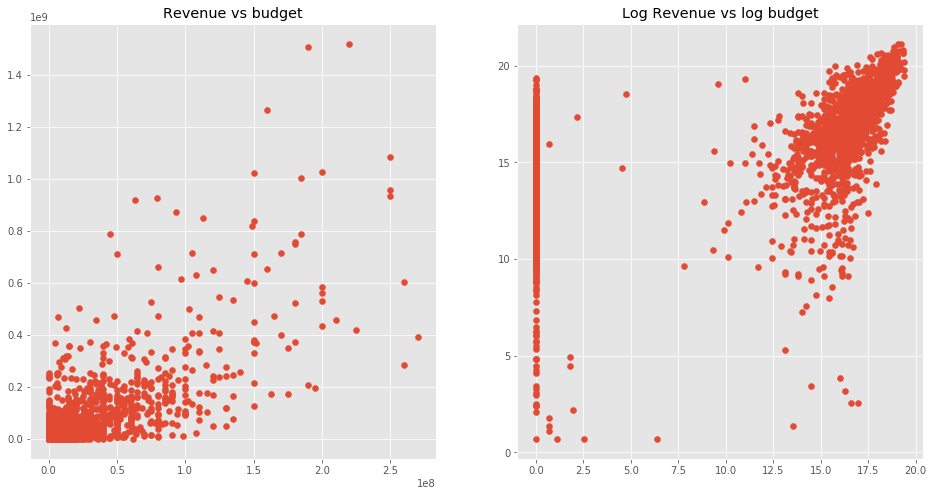

In [189]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

We can see that budget and revenue are somewhat correlated. Logarithm transformation makes budget distribution more managable.

In [190]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

<a id="homepage"></a>
### homepage

In [191]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/            3
http://www.lordoftherings.net/               2
http://thewomen.warnerbros.com/index.html    1
http://www.imdb.com/title/tt0095169/         1
http://www.d-9.com/                          1
Name: homepage, dtype: int64

Most of homepages are unique, so this feature may be useless.

In [192]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

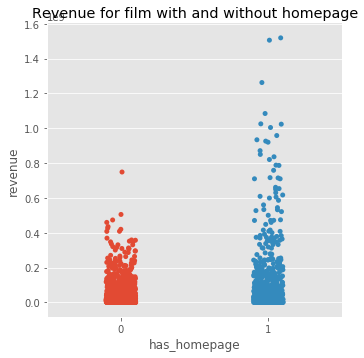

In [193]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

Films with homepage tend to generate more revenue! I suppose people can know more about the film thanks to homepage.

<a id="or_lang"></a>
### original_language

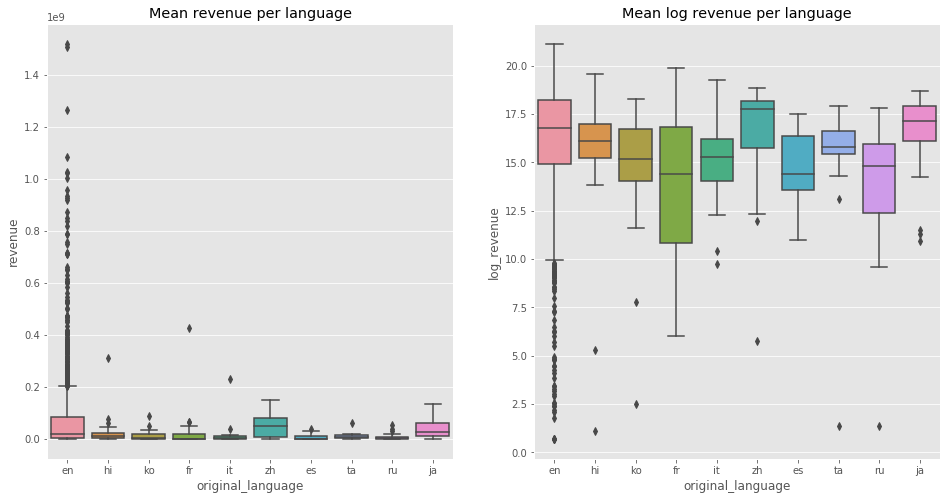

In [194]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

As we know there are much more english films and they have a higher range of values. Films with the highest revenue are usually in English, but there are also high revenue films in other languages.

<a id="or_title"></a>
### original_title

It can be interesting to see which words are common in titles.

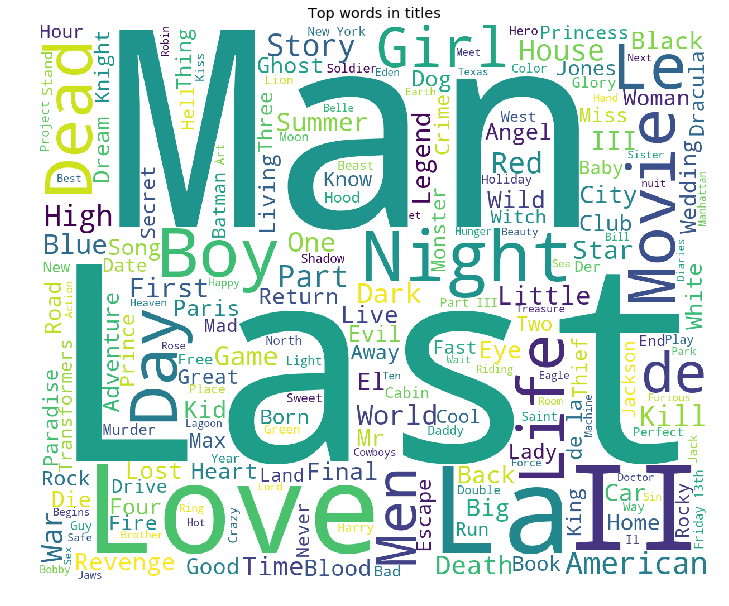

In [195]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

<a id="overview"></a>
### overview

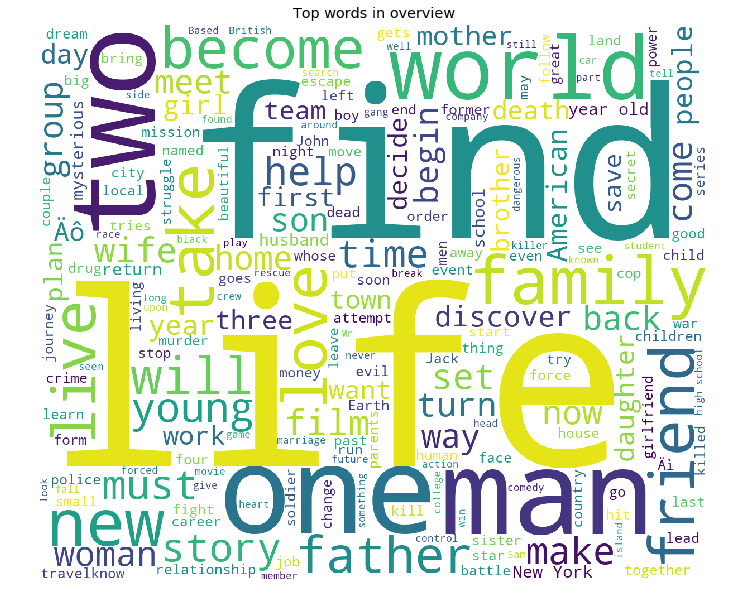

In [196]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

Let's try to see which words have high impact on the revenue. I'll build a simple model and use ELI5 for this.

In [197]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [198]:
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


We can see that some words can be used to predict revenue, but we will need more that overview text to build a good model.

<a id="popularity"></a>
### popularity

I'm not exactly sure what does popularity represents. Maybe it is some king of weighted rating, maybe something else. It seems it has low correlation with the target.

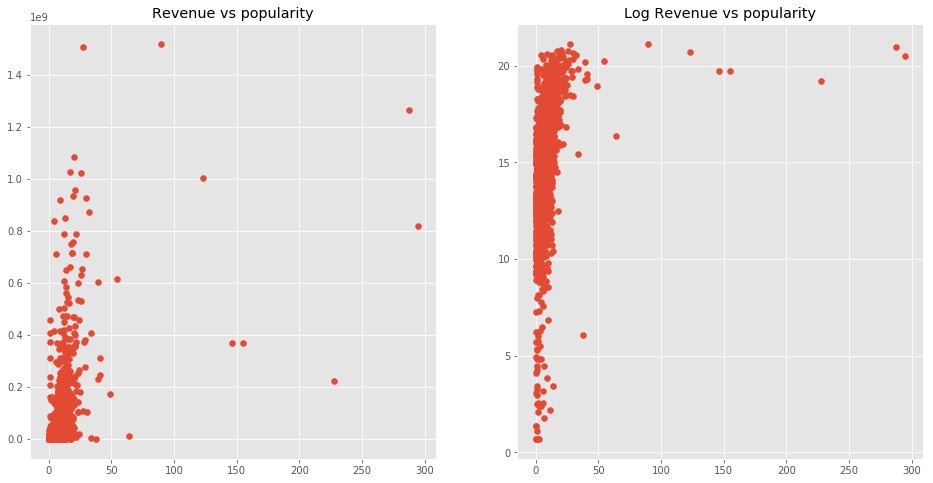

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity');

<a id="release_data"></a>
### release_date

In [ ]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [ ]:
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [ ]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [ ]:
# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

In [ ]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [ ]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [ ]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

We can see that number of films and total revenue are growing, which is to be expected. But there were some years in the past with a high number of successful films, which brought high revenue.

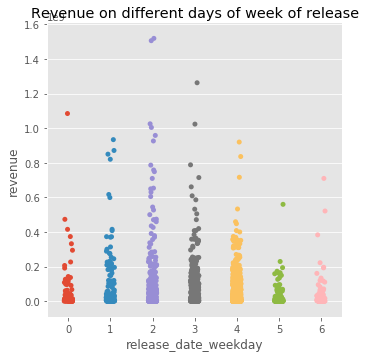

In [ ]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

Surprisingly films releases on Wednesdays and on Thursdays tend to have a higher revenue.

<a id="runtime"></a>
### runtime

The length of the film in minutes

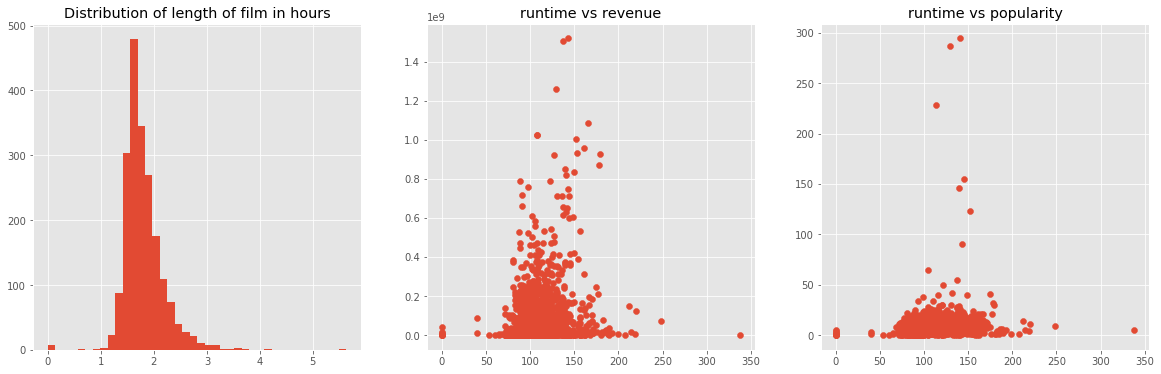

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

<a id="status"></a>
### Status

In [ ]:
train['status'].value_counts()

Released    1996
Rumored        4
Name: status, dtype: int64

In [ ]:
test['status'].value_counts()

Released    1000
Name: status, dtype: int64

AS we can see only 4 films in train data and 7 in test aren't released yet, so this feature is quite useless.

<a id="tagline"></a>
### tagline

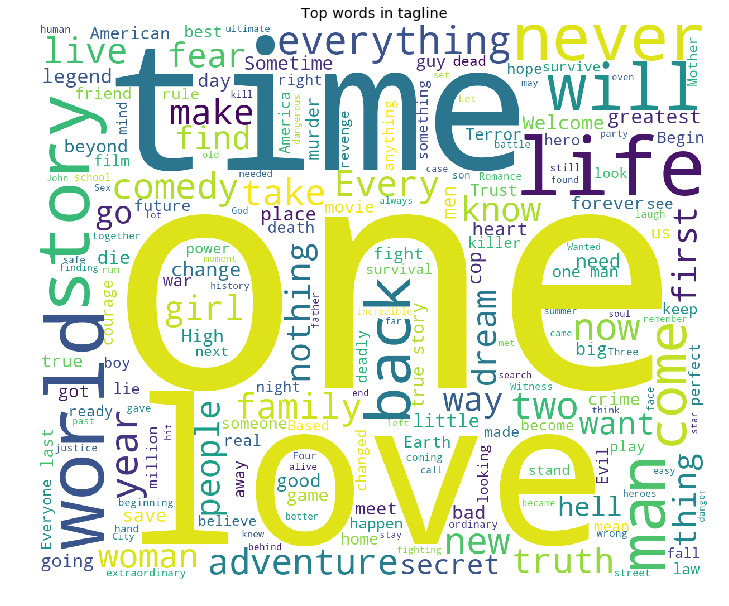

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

<a id="collections"></a>
### Collections

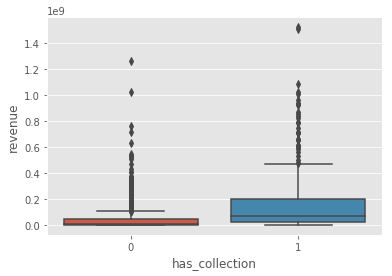

In [ ]:
sns.boxplot(x='has_collection', y='revenue', data=train);

Films, which are part of a collection usually have higher revenues. I suppose such films have a bigger fan base thanks to previous films.

<a id="genres_"></a>
### Genres

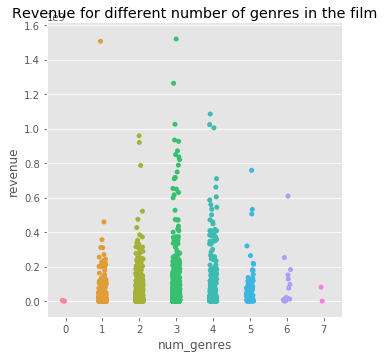

In [ ]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

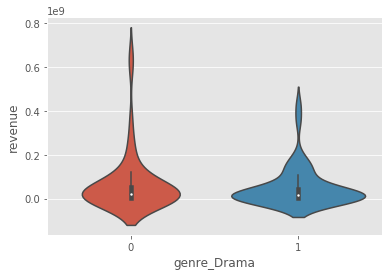

In [ ]:
sns.violinplot(x='genre_Drama', y='revenue', data=train[:100]);

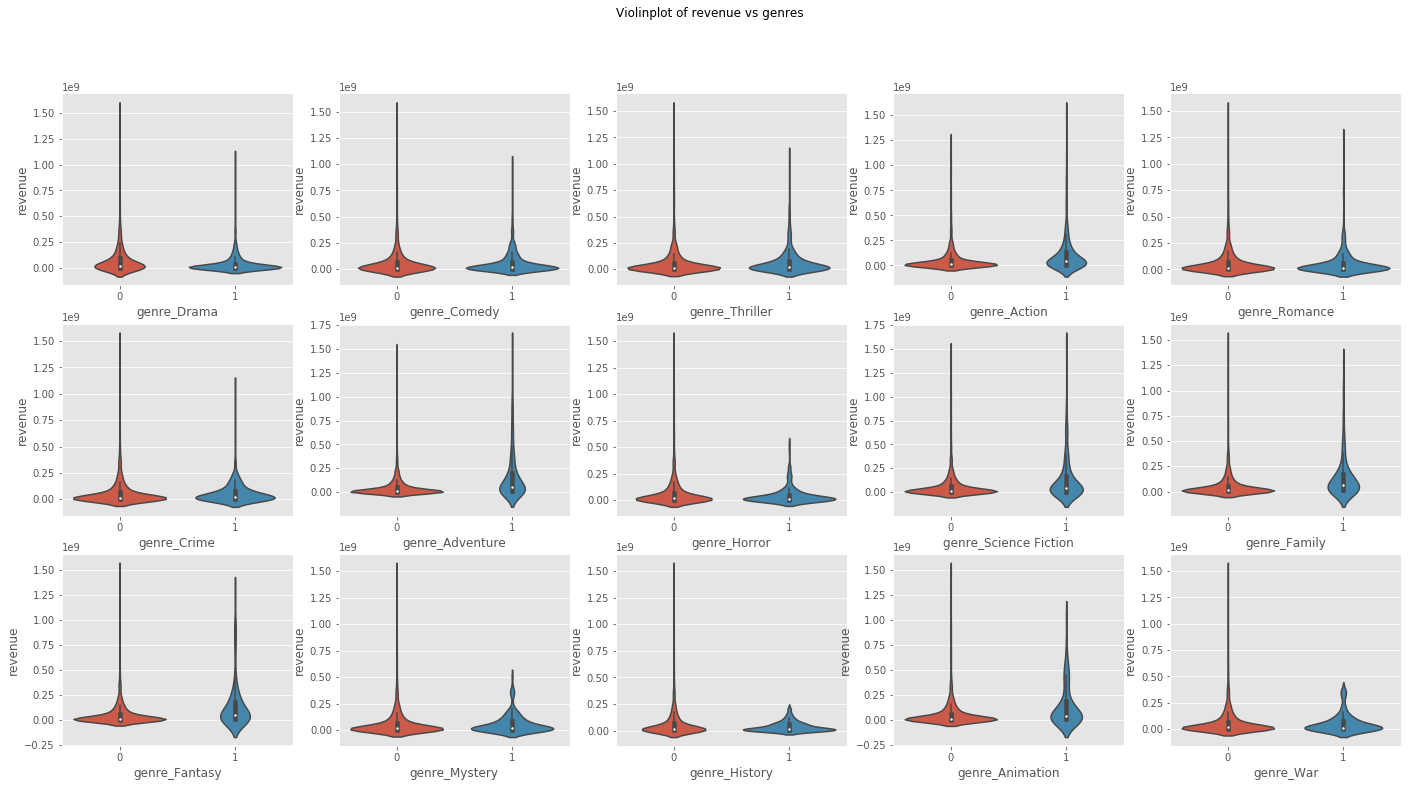

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

Some genres tend to have less revenue, some tend to have higher.

<a id="prod_comp"></a>
### Production companies

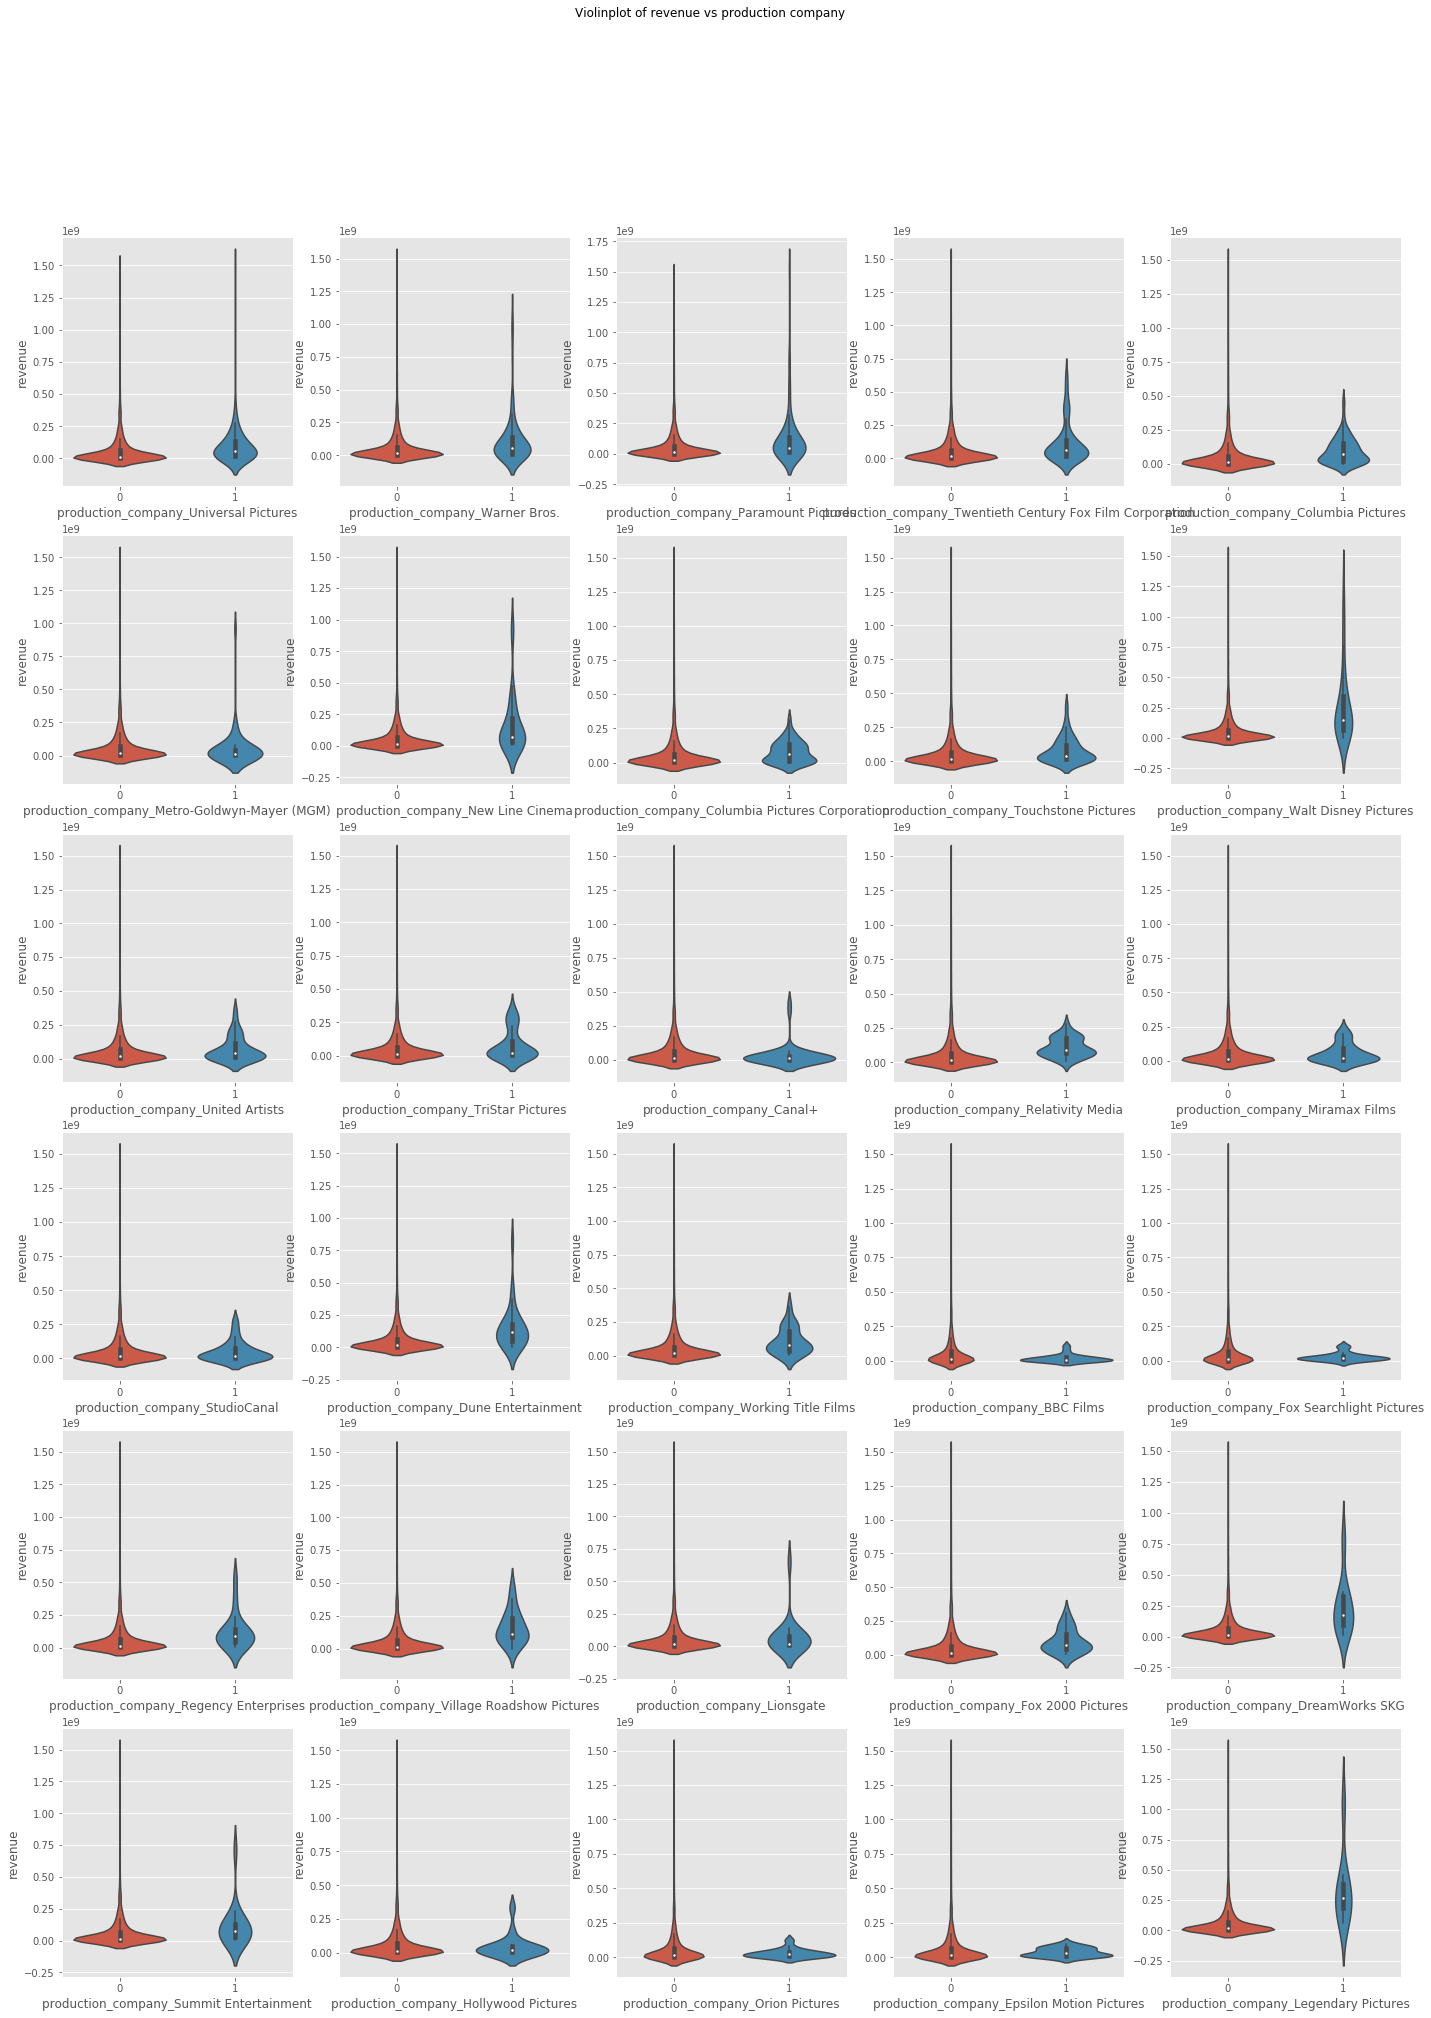

In [ ]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

There are only a couple of companies, which have distinctly higher revenues compared to others.

<a id="prod_count"></a>
### Production countries

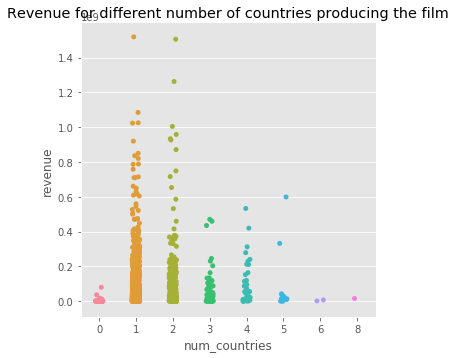

In [ ]:
sns.catplot(x='num_countries', y='revenue', data=train);
plt.title('Revenue for different number of countries producing the film');

In fact I think that number of production countries hardly matters. Most films are produced by 1-2 companies, so films with 1-2 companies have the highest revenue.

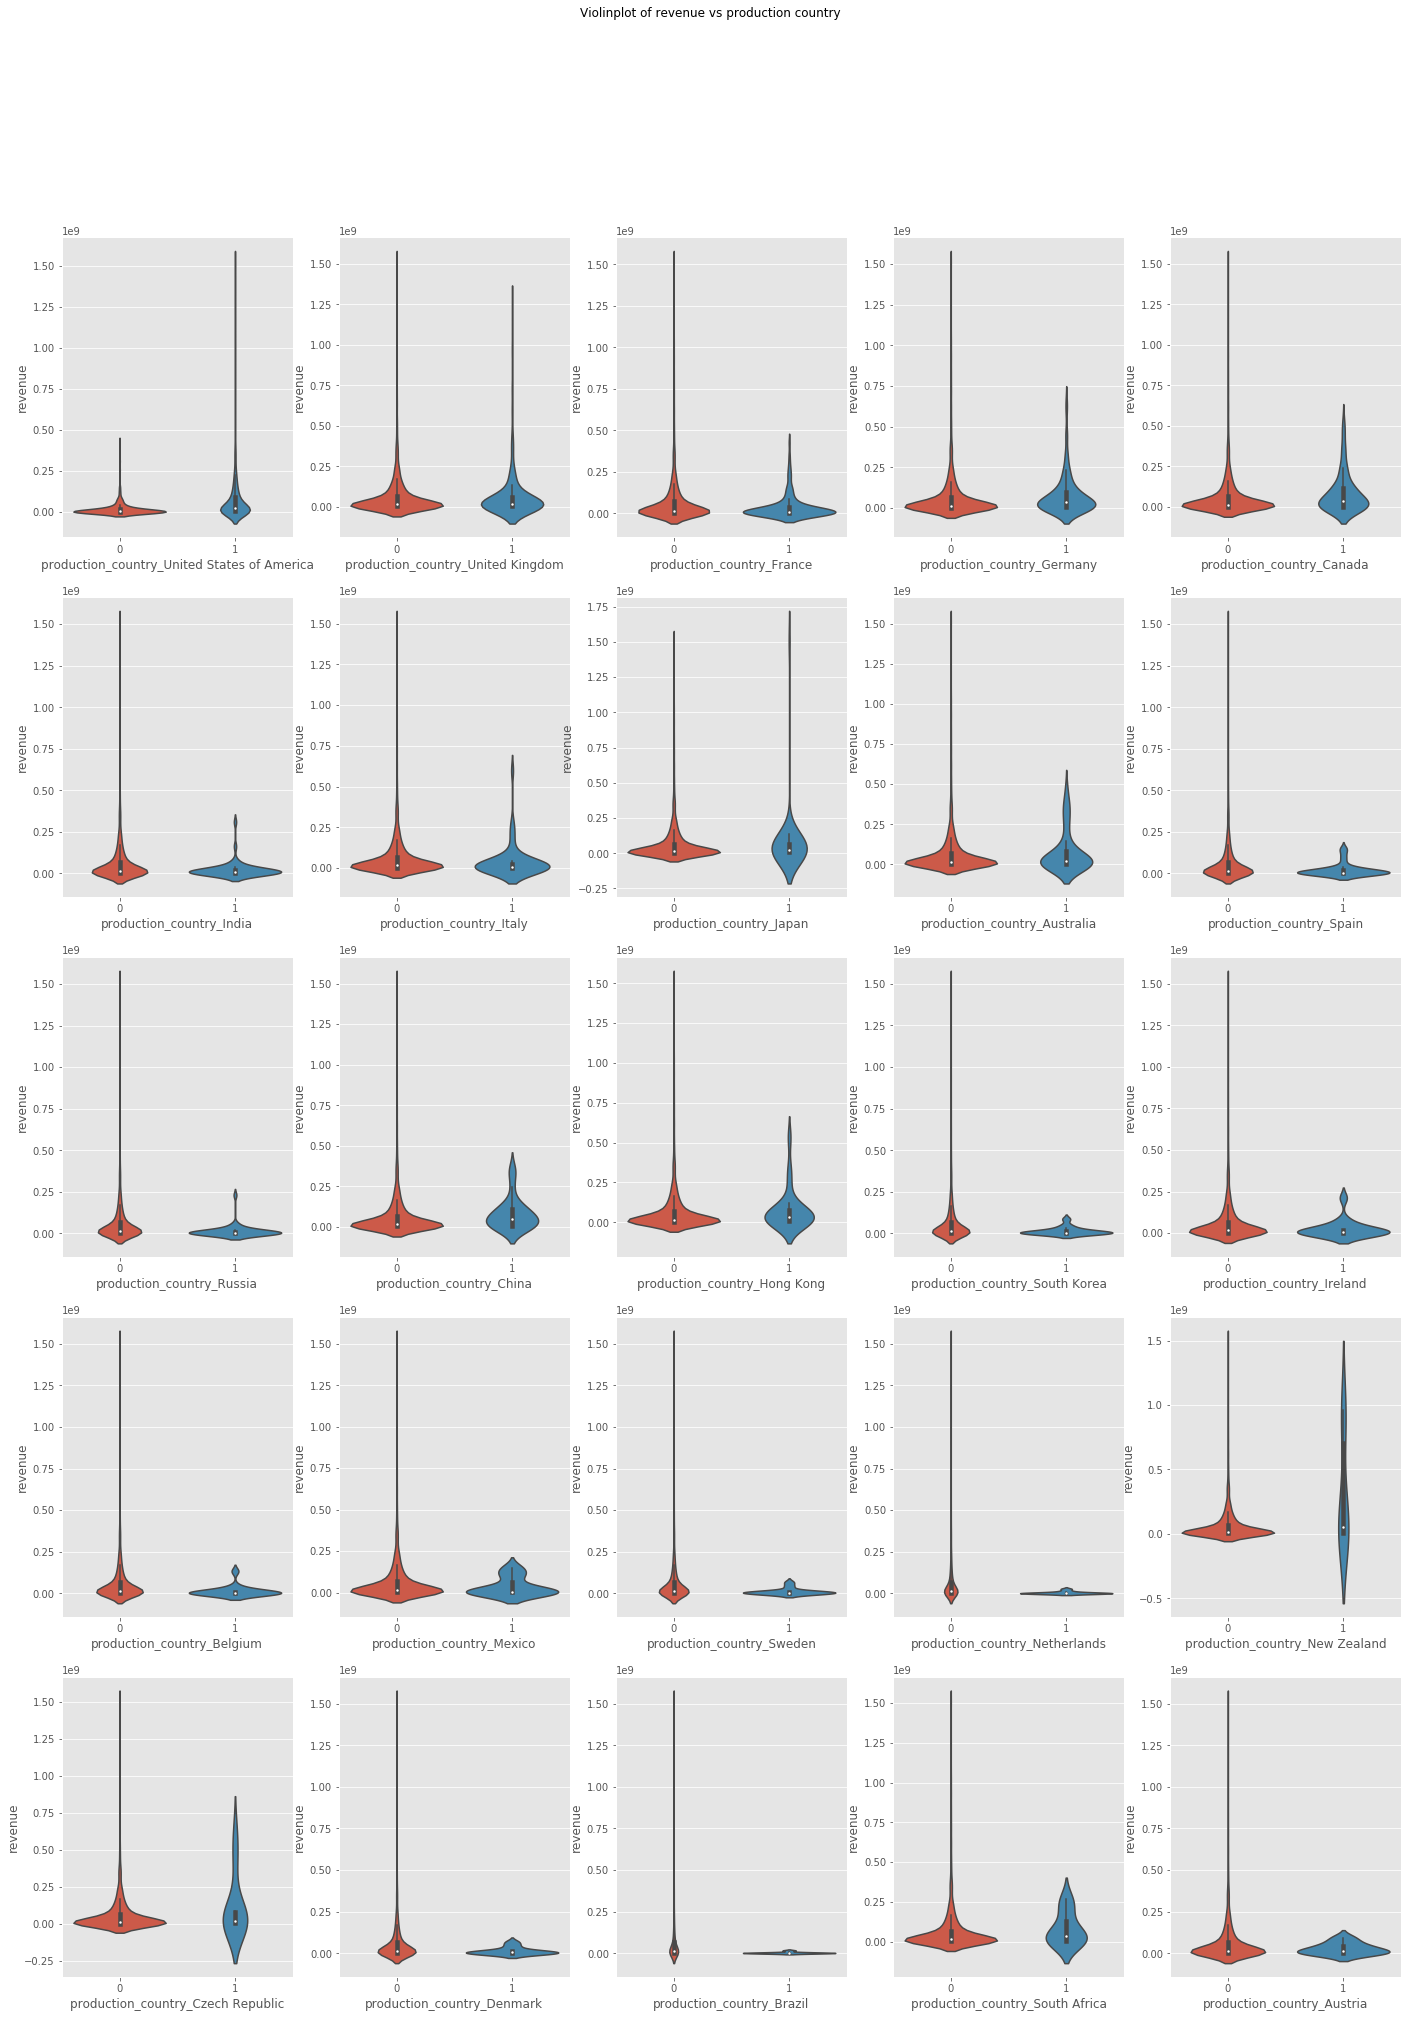

In [ ]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

There are only a couple of countries, which have distinctly higher revenues compared to others.

<a id="cast_viz"></a>
### Cast

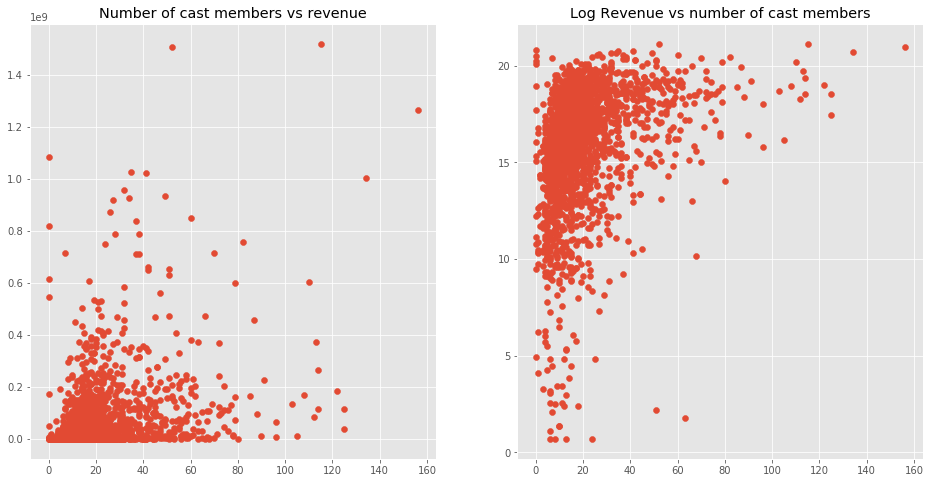

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');

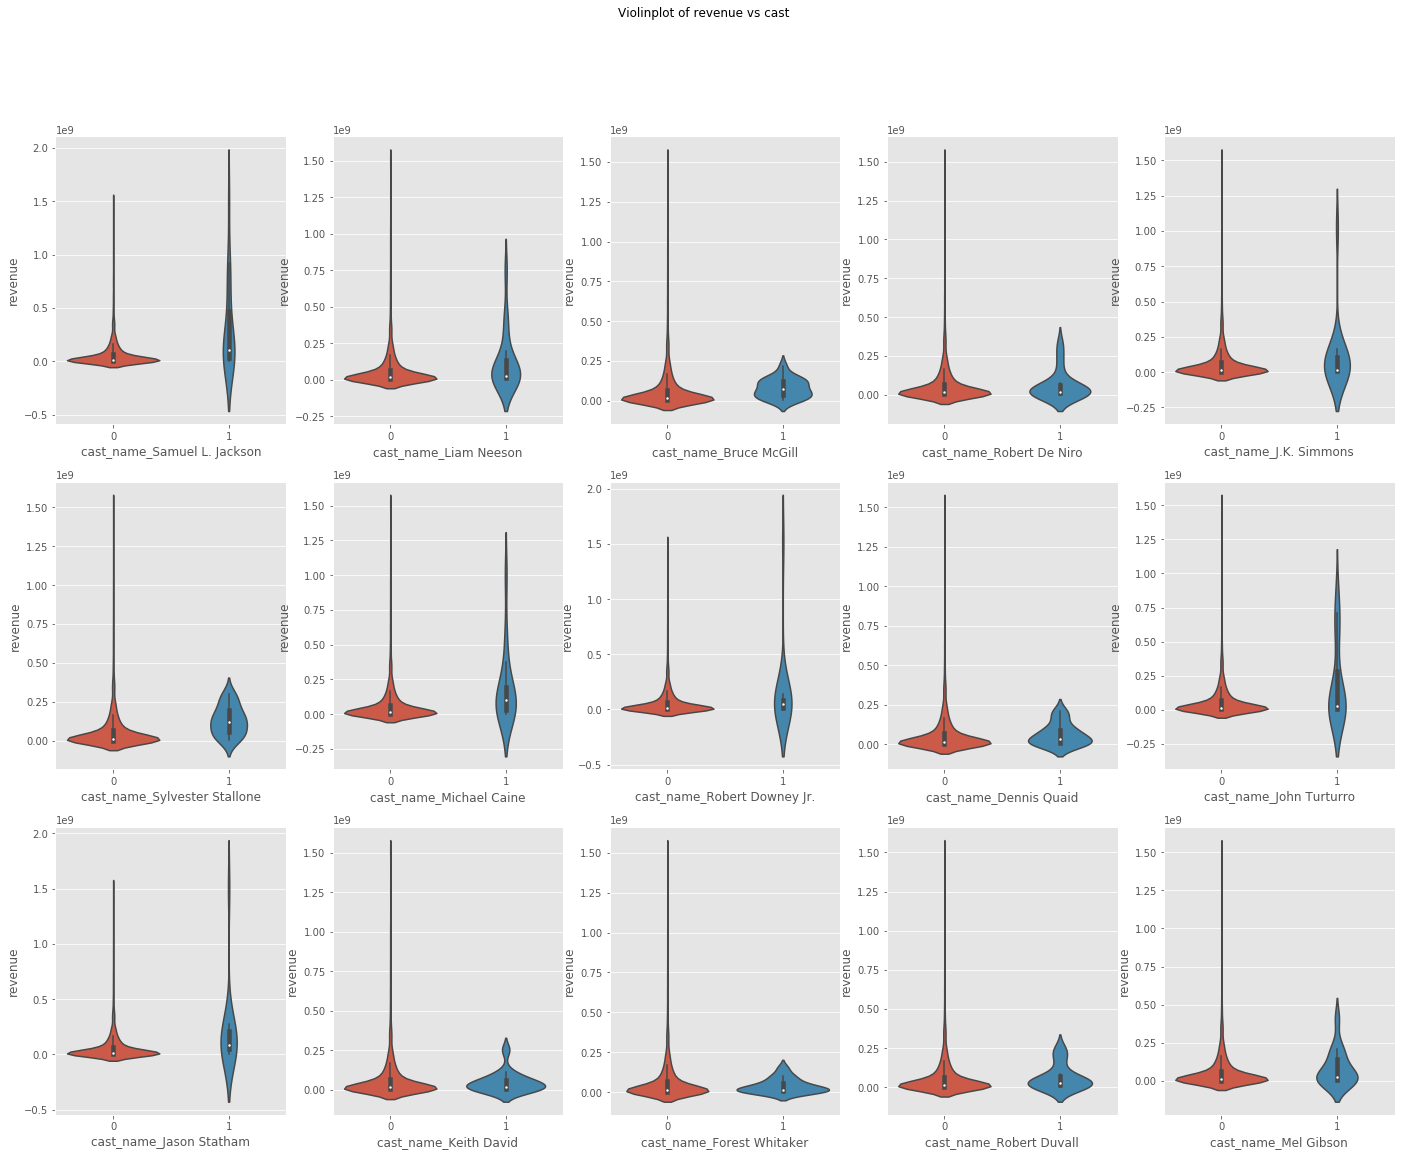

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

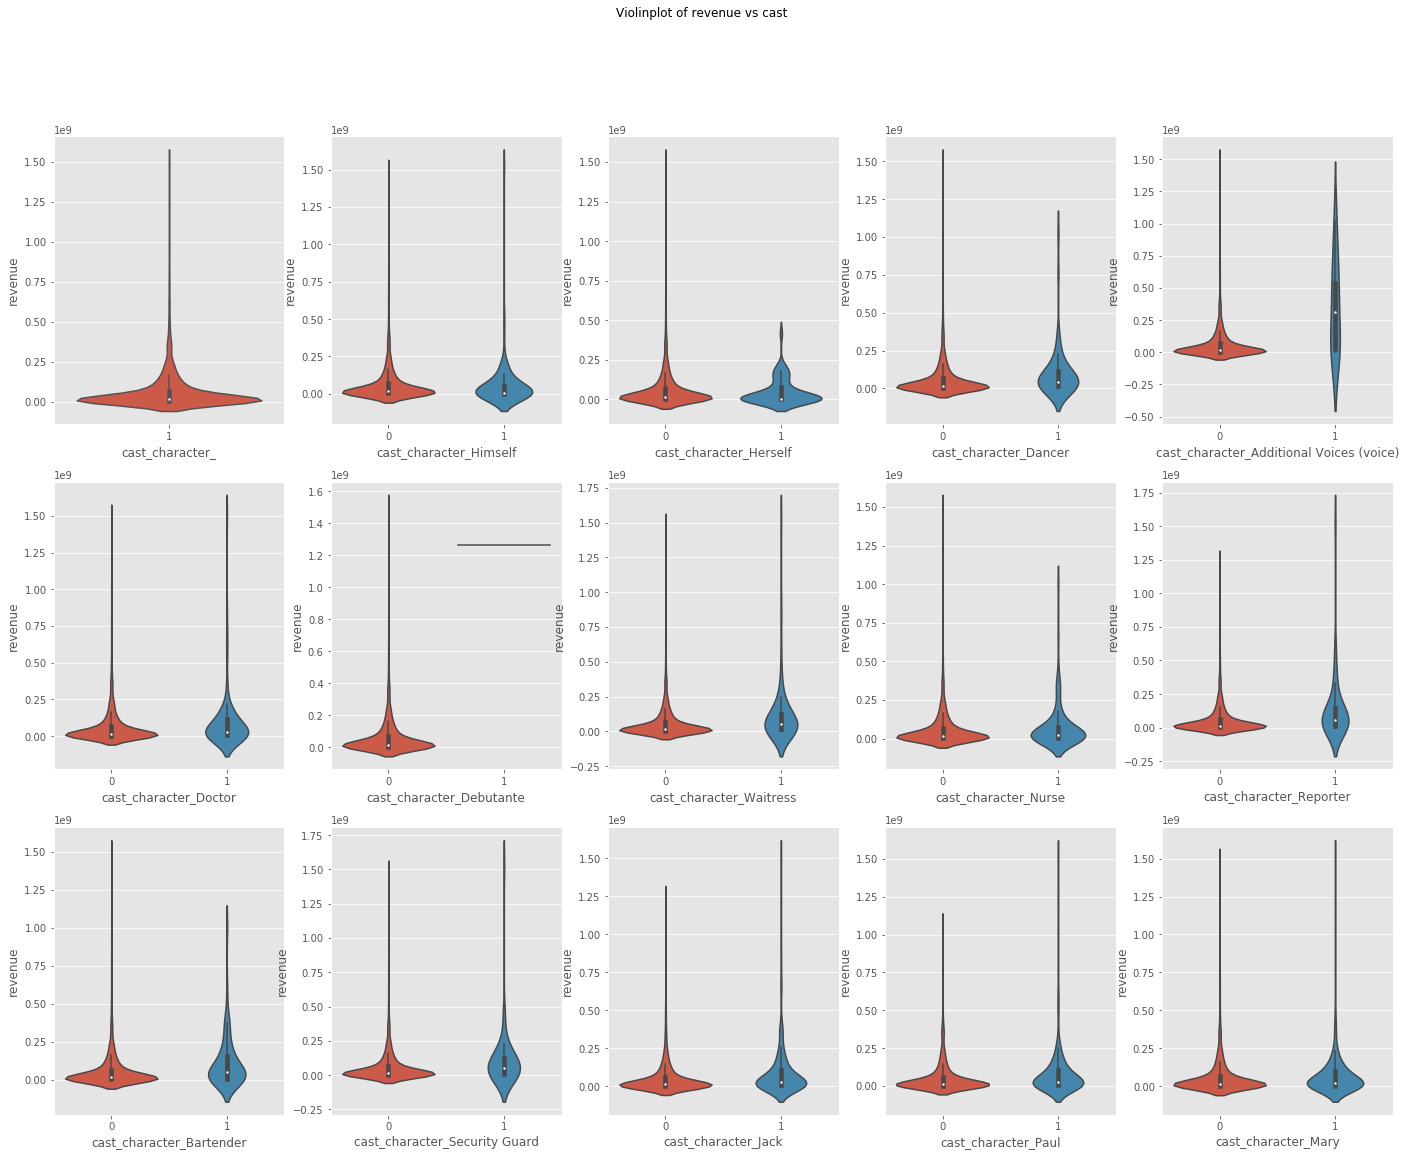

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="key_viz"></a>
### Keywords

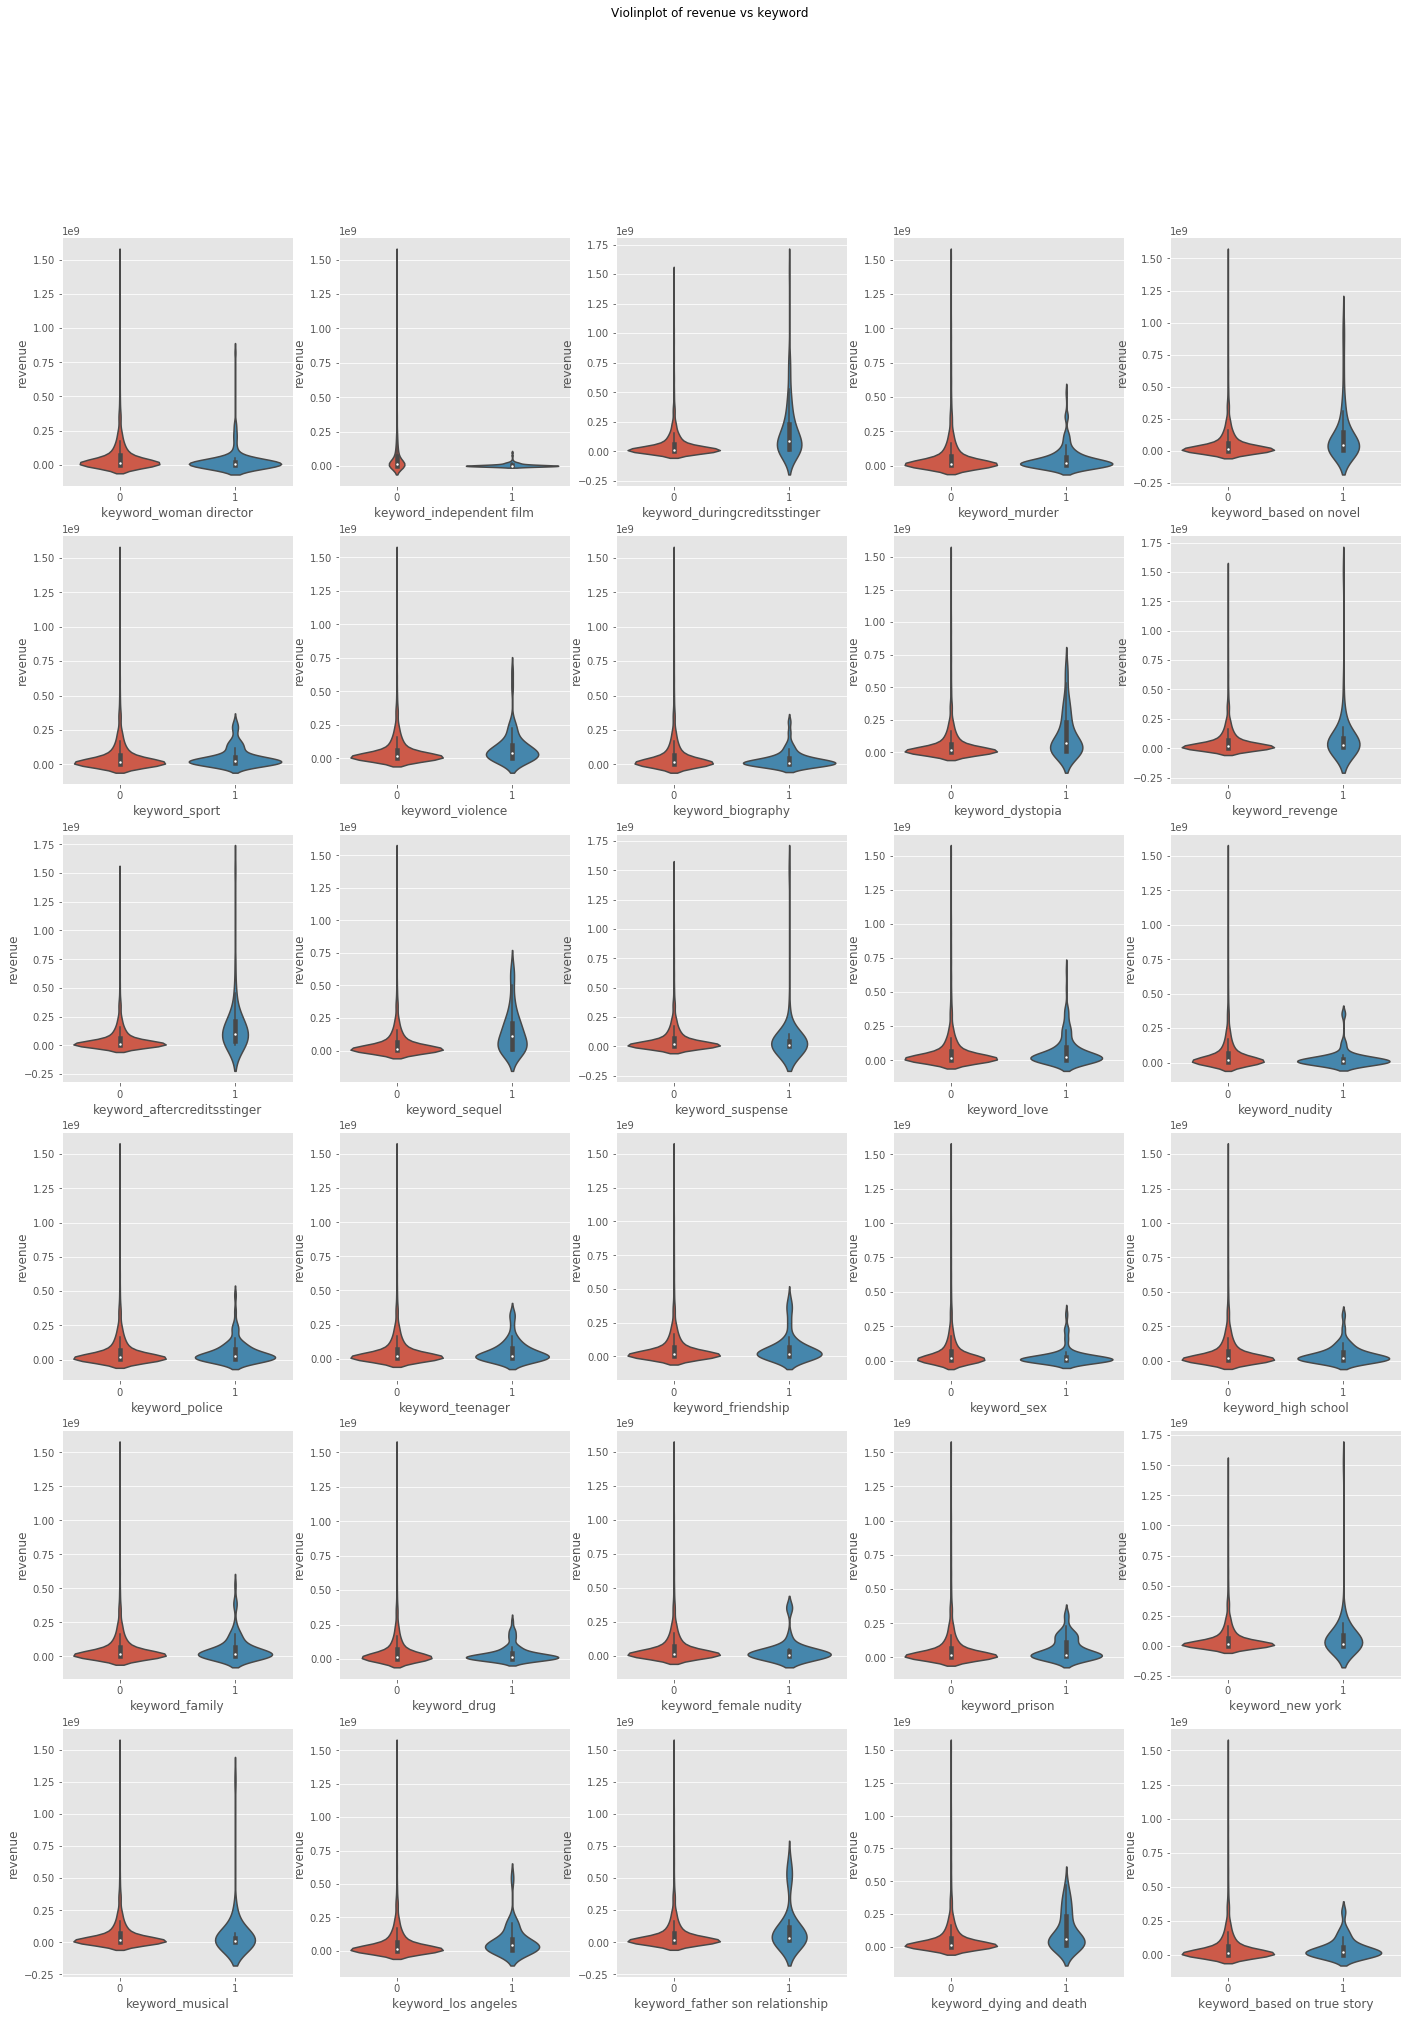

In [ ]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="crew_viz"></a>
### Crew

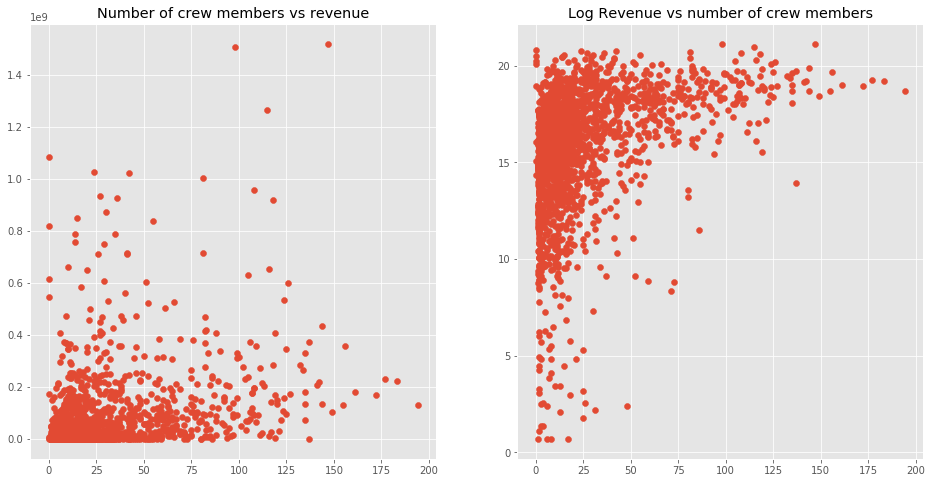

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

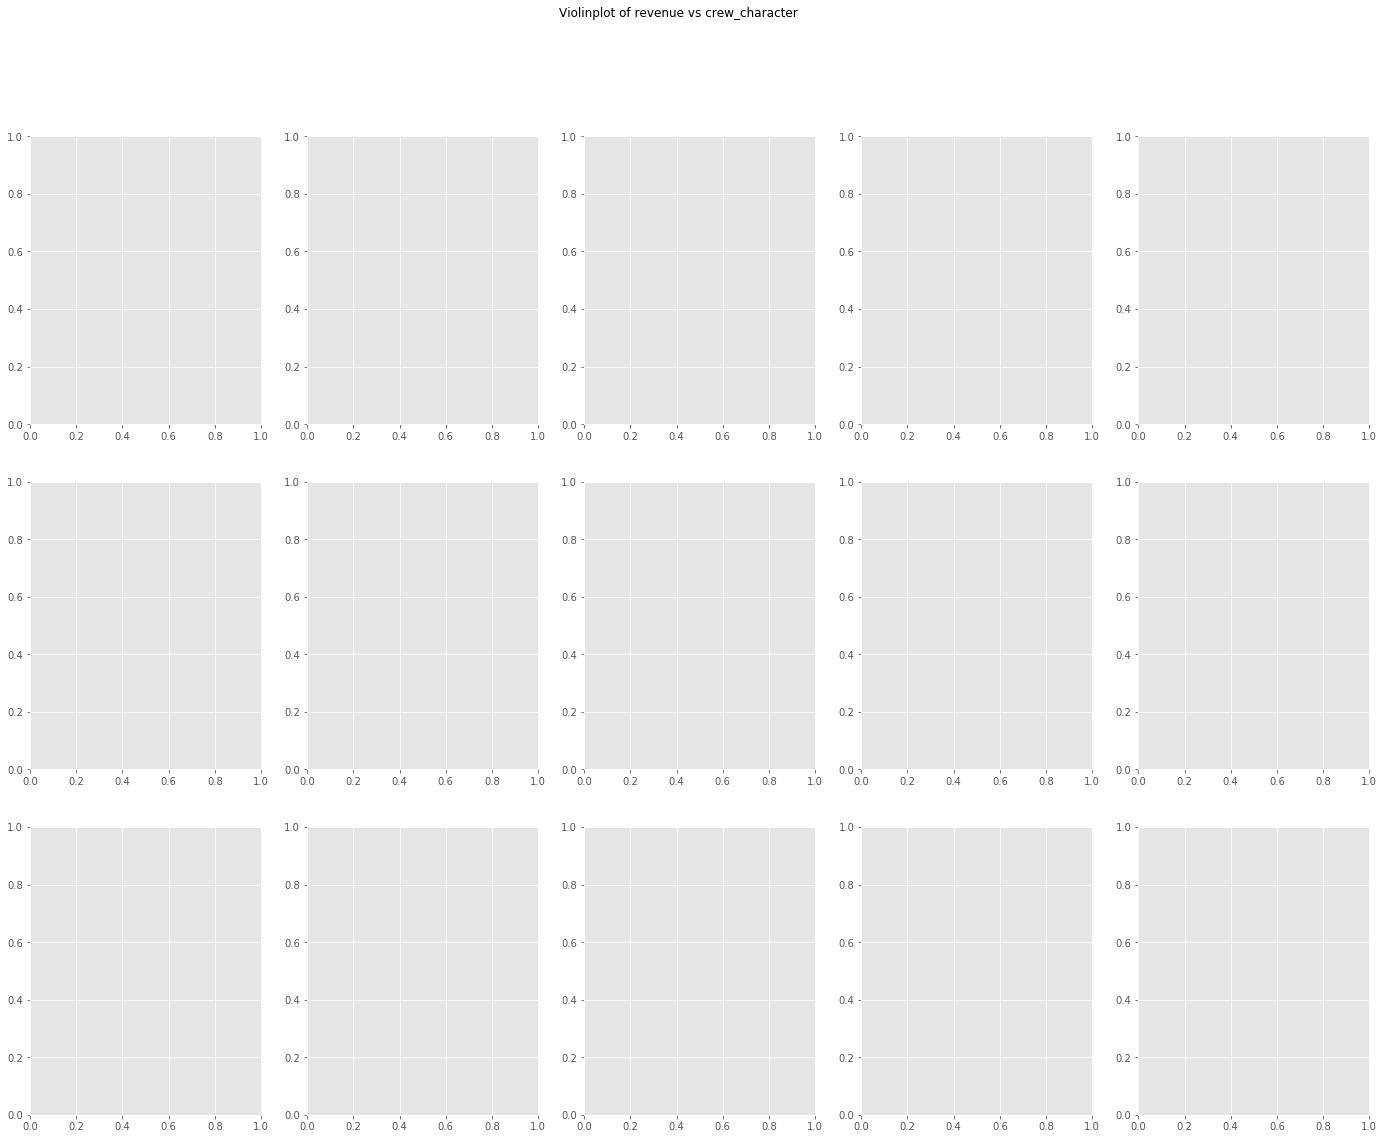

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_character')
for i, e in enumerate([col for col in train.columns if 'crew_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

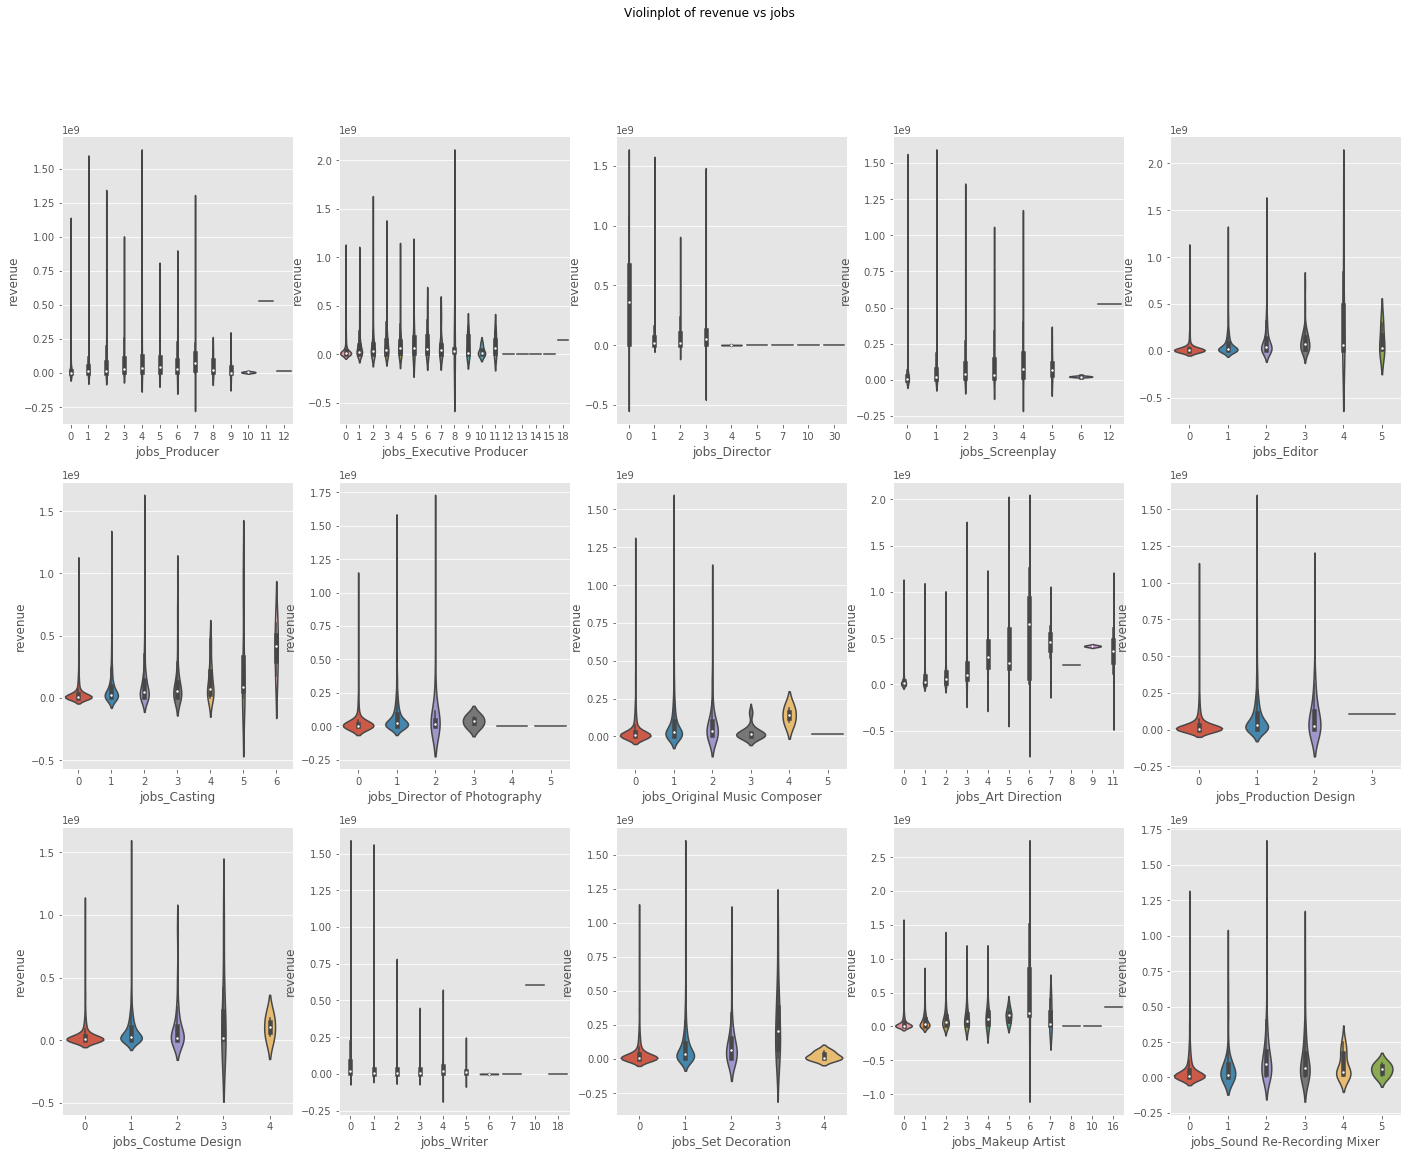

In [ ]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

<a id="basic_model"></a>
## Modelling and feature generation

In [ ]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [ ]:
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

language_
cast_character_


In [ ]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [ ]:
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

In [ ]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

In [ ]:
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [ ]:
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id'], axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.21801	valid_1's rmse: 2.42469
[2000]	training's rmse: 0.878433	valid_1's rmse: 2.3933
[3000]	training's rmse: 0.651734	valid_1's rmse: 2.3786
[4000]	training's rmse: 0.484769	valid_1's rmse: 2.36829
Early stopping, best iteration is:
[4304]	training's rmse: 0.444578	valid_1's rmse: 2.36619


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l1=0.2, learning_rate=0.01, max_depth=5, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
       min_split_gain=0.0, n_estimators=20000, n_jobs=-1, nthread=4,
       num_leaves=30, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [ ]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Mon May 27 17:22:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.09775	valid_1's rmse: 1.93441
Early stopping, best iteration is:
[919]	training's rmse: 1.13235	valid_1's rmse: 1.93199
Fold 1 started at Mon May 27 17:22:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[399]	training's rmse: 1.4433	valid_1's rmse: 2.11128
Fold 2 started at Mon May 27 17:22:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.11716	valid_1's rmse: 1.98098
Early stopping, best iteration is:
[1532]	training's rmse: 0.89916	valid_1's rmse: 1.96316
Fold 3 started at Mon May 27 17:22:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.09812	valid_1's rmse: 1.74475
Early stopping, best iteration is:
[831]	training's rmse: 1.1777	valid_1's rmse: 1.73998
Fold 4 started at Mon May 27 17:22:46 2019
Traini

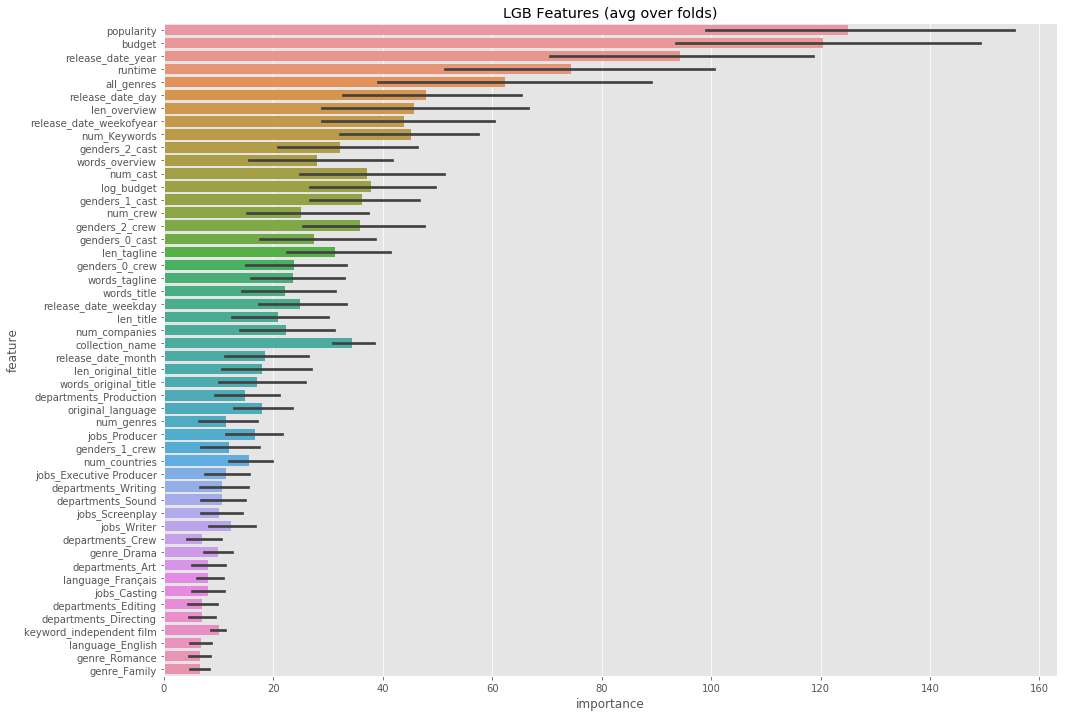

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="oof"></a>
### OOF features based on texts

In [ ]:
for col in train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

Fold 0 started at Mon May 27 17:23:25 2019
Fold 1 started at Mon May 27 17:23:27 2019
Fold 2 started at Mon May 27 17:23:29 2019
Fold 3 started at Mon May 27 17:23:30 2019
Fold 4 started at Mon May 27 17:23:32 2019
Fold 5 started at Mon May 27 17:23:34 2019
Fold 6 started at Mon May 27 17:23:36 2019
Fold 7 started at Mon May 27 17:23:38 2019
Fold 8 started at Mon May 27 17:23:39 2019
Fold 9 started at Mon May 27 17:23:41 2019
CV mean score: 3.0158, std: 0.3017.
Fold 0 started at Mon May 27 17:23:42 2019
Fold 1 started at Mon May 27 17:23:44 2019
Fold 2 started at Mon May 27 17:23:46 2019
Fold 3 started at Mon May 27 17:23:48 2019
Fold 4 started at Mon May 27 17:23:51 2019
Fold 5 started at Mon May 27 17:23:53 2019
Fold 6 started at Mon May 27 17:23:55 2019
Fold 7 started at Mon May 27 17:23:57 2019
Fold 8 started at Mon May 27 17:23:59 2019
Fold 9 started at Mon May 27 17:24:01 2019
CV mean score: 2.9367, std: 0.2668.
Fold 0 started at Mon May 27 17:24:06 2019
Fold 1 started at Mon May

<a id="add_feat"></a>
### Additional feature generation

In [ ]:
X.head()

budget  original_language  popularity  runtime  collection_name  \
0  14000000                  7    6.575393     93.0              152   
1  40000000                  7    8.248895    113.0              366   
2   3300000                  7   64.299990    105.0                1   
3   1200000                 13    3.174936    122.0                1   
4         0                 18    1.148070    118.0                1   

   has_collection  num_genres  all_genres  genre_Drama  genre_Comedy  \
0               1           1         305            0             1   
1               1           4         330            1             1   
2               0           1         435            1             0   
3               0           2         486            1             0   
4               0           2         194            0             0   

   genre_Thriller  genre_Action  genre_Romance  genre_Crime  genre_Adventure  \
0               0             0              0            0                0   
1               0             0              1            0                0   
2               0             0              0            0                0   
3               1             0              0            0                0   
4               1             1              0            0                0   

   genre_Horror  genre_Science Fiction  genre_Family  genre_Fantasy  \
0             0                      0             0              0   
1             0                      0             1              0   
2             0                      0             0              0   
3             0                      0             0              0   
4             0                      0             0              0   

   genre_Mystery  genre_History  genre_Animation  genre_War  num_companies  \
0              0              0                0          0              3   
1              0              0                0          0              1   
2              0              0                0          0              3   
3              0              0                0          0              0   
4              0              0                0          0              0   

   production_company_Universal Pictures  production_company_Warner Bros.  \
0                                      0                                0   
1                                      0                                0   
2                                      0                                0   
3                                      0                                0   
4                                      0                                0   

   production_company_Paramount Pictures  \
0                                      1   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   production_company_Twentieth Century Fox Film Corporation  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   production_company_Columbia Pictures  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   production_company_Metro-Goldwyn-Mayer (MGM)  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   production_company_New Line Cinema  \
0                                   0   
1

In [ ]:
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    # some features from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df

In [ ]:
X = new_features(X)
X_test = new_features(X_test)

Fold 0 started at Mon May 27 17:25:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.01003	valid_1's rmse: 1.89381
Early stopping, best iteration is:
[1212]	training's rmse: 0.912278	valid_1's rmse: 1.88665
Fold 1 started at Mon May 27 17:25:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[476]	training's rmse: 1.33348	valid_1's rmse: 2.00688
Fold 2 started at Mon May 27 17:26:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.02291	valid_1's rmse: 1.98168
Early stopping, best iteration is:
[1201]	training's rmse: 0.922996	valid_1's rmse: 1.97399
Fold 3 started at Mon May 27 17:26:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[465]	training's rmse: 1.33257	valid_1's rmse: 1.79076
Fold 4 started at Mon May 27 17:26:14 2019
Training until validation scores don't improve for 200 ro

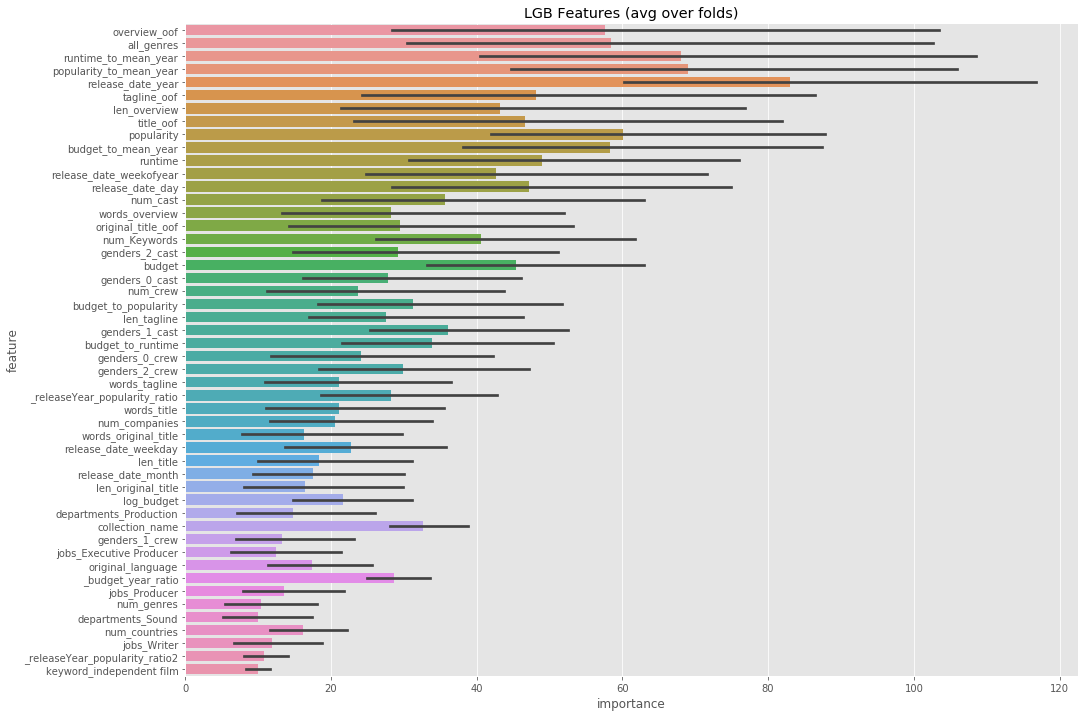

In [ ]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="imp_feats"></a>
### Important features

Let's have a look at important features using ELI5 and SHAP!

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.978583	valid_1's rmse: 1.91114
Early stopping, best iteration is:
[848]	training's rmse: 1.06568	valid_1's rmse: 1.90895


We can see that important features native to LGB and top features in ELI5 are mostly similar. This means that our model is quite good at working with these features.

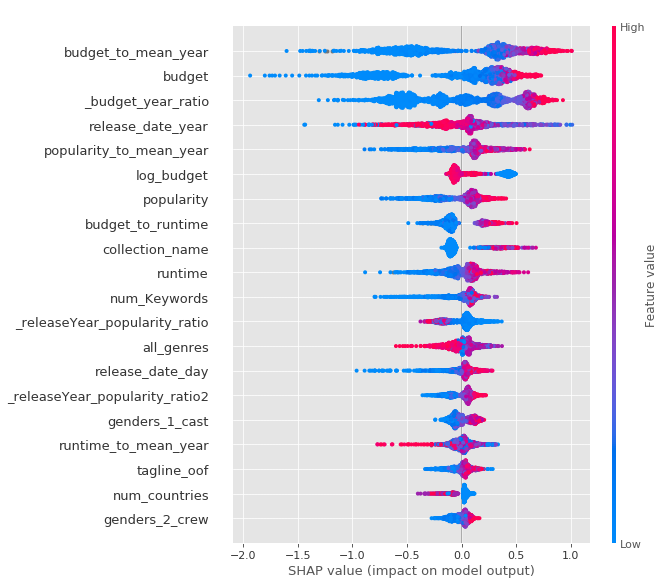

In [ ]:
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

SHAP provides more detailed information even if it may be more difficult to understand.

For example low budget has negavite impact on revenue, while high values usually tend to have higher revenue.

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



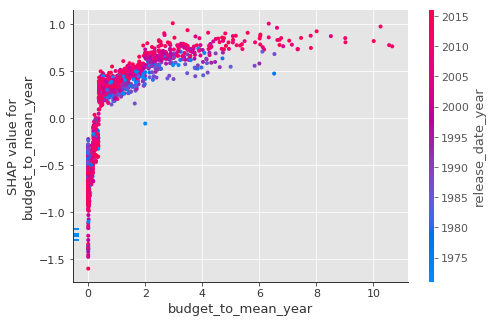

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



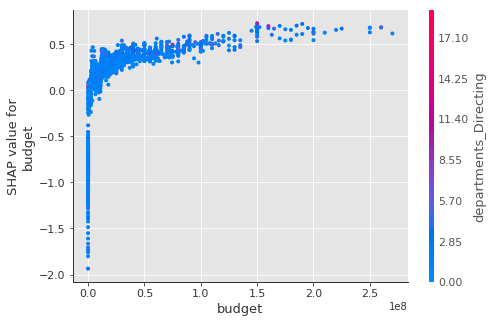

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



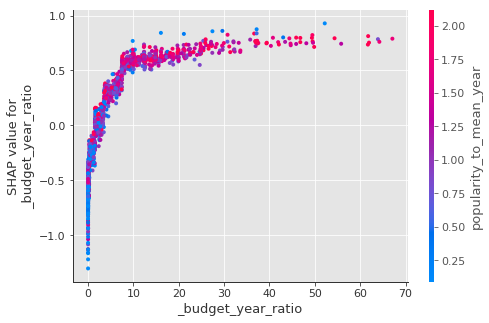

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



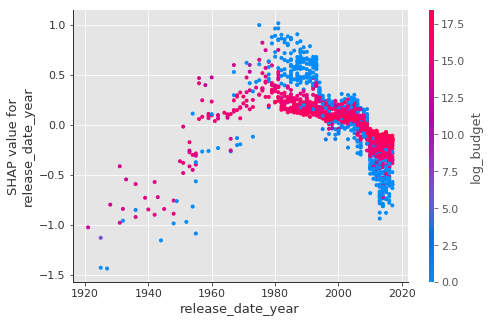

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



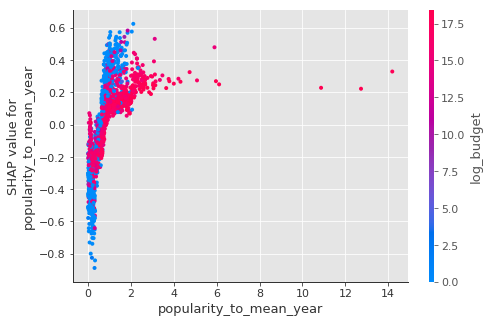

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



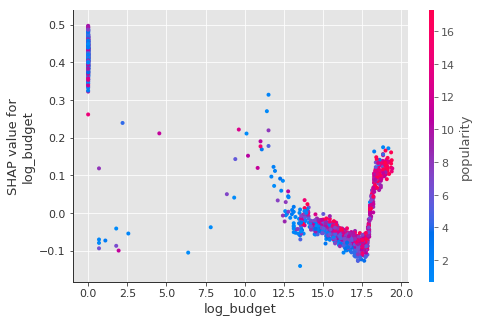

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



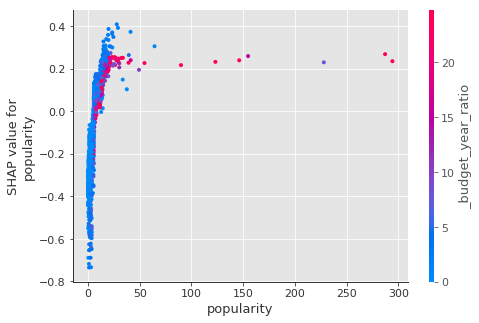

C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



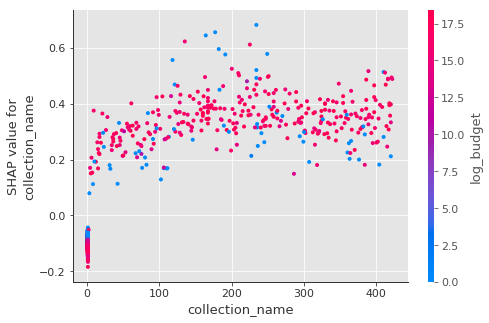

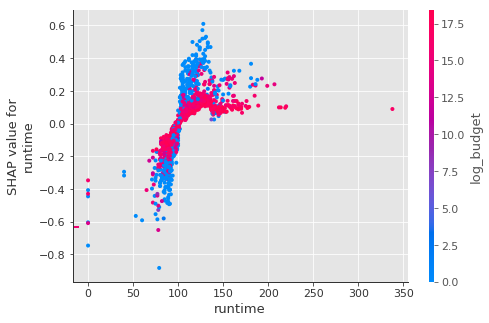

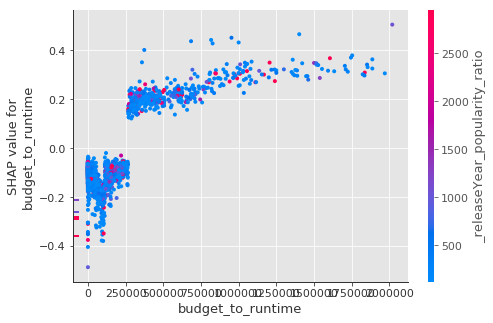

In [ ]:
top_cols = X_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]
for col in top_cols:
    shap.dependence_plot(col, shap_values, X_train)

Here we can see interactions between important features. There are some interesting things here. For example relationship between release_date_year and log_budget. Up to ~1990 low budget films brought higher revenues, but after 2000 year high budgets tended to be correlated with higher revenues. And in genereal the effect of budget diminished.

Let's create new features as interactions between top important features. Some of them make little sense, but maybe they could improve the model.

In [ ]:
def top_cols_interaction(df):
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
    df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
    df['genders_1_cast_to_log_budget'] = df['genders_1_cast'] / df['log_budget']
    df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
    df['genders_2_crew_to_budget_to_mean_year'] = df['genders_2_crew'] / df['budget_to_mean_year']
    df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['genders_2_crew']
    
    return df

In [ ]:
X = top_cols_interaction(X)
X_test = top_cols_interaction(X_test)

In [ ]:
X = X.replace([np.inf, -np.inf], 0).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

<a id="ext_feats"></a>
### External features
I'm adding external features from this kernel: https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat by kamalchhirang. All credit for these features goes to him and his kernel.

In [ ]:
#trainAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TrainAdditionalFeatures.csv')
#testAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TestAdditionalFeatures.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X['imdb_id'] = train['imdb_id']
X_test['imdb_id'] = test['imdb_id']
del train, test

#X = pd.merge(X, trainAdditionalFeatures, how='left', on=['imdb_id'])
#X_test = pd.merge(X_test, testAdditionalFeatures, how='left', on=['imdb_id'])

X = X.drop(['imdb_id'], axis=1)
X_test = X_test.drop(['imdb_id'], axis=1)

In [ ]:
X.head()

budget  original_language  popularity  runtime  collection_name  \
0  14000000                  7    6.575393     93.0              152   
1  40000000                  7    8.248895    113.0              366   
2   3300000                  7   64.299990    105.0                1   
3   1200000                 13    3.174936    122.0                1   
4         0                 18    1.148070    118.0                1   

   has_collection  num_genres  all_genres  genre_Drama  genre_Comedy  \
0               1           1         305            0             1   
1               1           4         330            1             1   
2               0           1         435            1             0   
3               0           2         486            1             0   
4               0           2         194            0             0   

   genre_Thriller  genre_Action  genre_Romance  genre_Crime  genre_Adventure  \
0               0             0              0            0                0   
1               0             0              1            0                0   
2               0             0              0            0                0   
3               1             0              0            0                0   
4               1             1              0            0                0   

   genre_Horror  genre_Science Fiction  genre_Family  genre_Fantasy  \
0             0                      0             0              0   
1             0                      0             1              0   
2             0                      0             0              0   
3             0                      0             0              0   
4             0                      0             0              0   

   genre_Mystery  genre_History  genre_Animation  genre_War  num_companies  \
0              0              0                0          0              3   
1              0              0                0          0              1   
2              0              0                0          0              3   
3              0              0                0          0              0   
4              0              0                0          0              0   

   production_company_Universal Pictures  production_company_Warner Bros.  \
0                                      0                                0   
1                                      0                                0   
2                                      0                                0   
3                                      0                                0   
4                                      0                                0   

   production_company_Paramount Pictures  \
0                                      1   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   production_company_Twentieth Century Fox Film Corporation  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   production_company_Columbia Pictures  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   production_company_Metro-Goldwyn-Mayer (MGM)  \
0                                             1   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   production_company_New Line Cinema  \
0                                   0   
1

Fold 0 started at Mon May 27 17:28:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.763549	valid_1's rmse: 1.80848
Early stopping, best iteration is:
[1437]	training's rmse: 0.550091	valid_1's rmse: 1.79973
Fold 1 started at Mon May 27 17:28:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[794]	training's rmse: 0.890672	valid_1's rmse: 2.06851
Fold 2 started at Mon May 27 17:28:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.788007	valid_1's rmse: 1.99035
Early stopping, best iteration is:
[1245]	training's rmse: 0.651037	valid_1's rmse: 1.98699
Fold 3 started at Mon May 27 17:28:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[191]	training's rmse: 1.63507	valid_1's rmse: 1.93658
Fold 4 started at Mon May 27 17:28:47 2019
Training until validation scores don't improve for 200

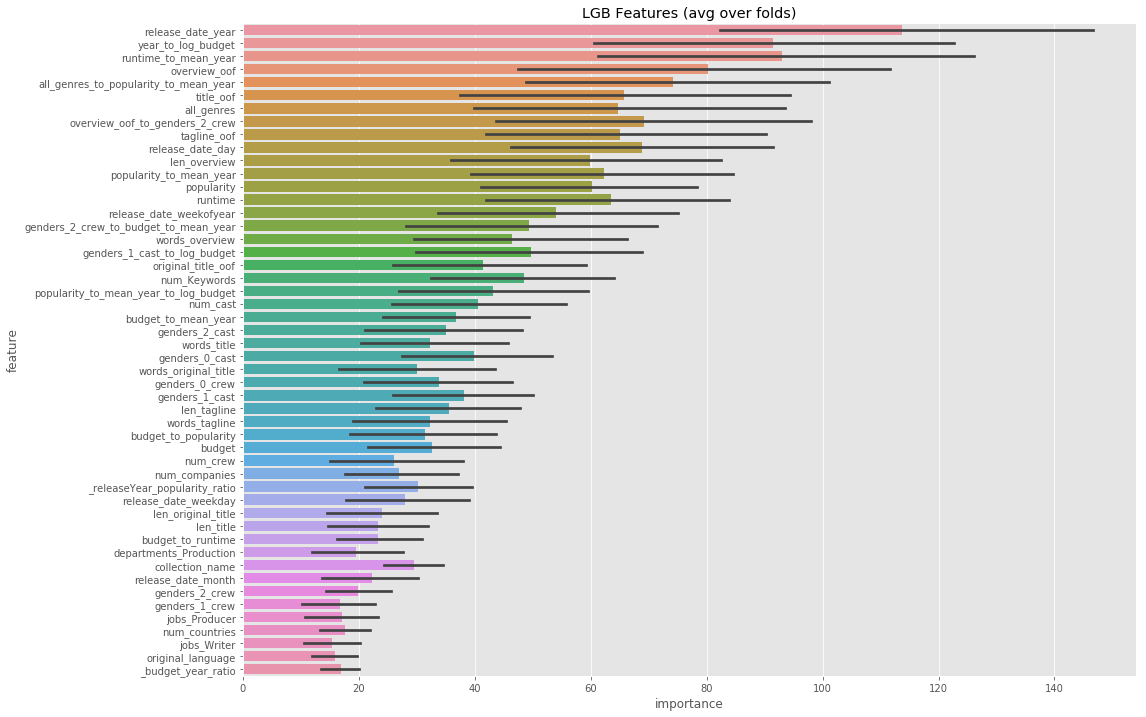

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

<a id="blending"></a>
### Blending

In [ ]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Mon May 27 17:29:56 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.577	valid_data-rmse:15.7261
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.820163	valid_data-rmse:1.83452
[1000]	train-rmse:0.428525	valid_data-rmse:1.80643
[1500]	train-rmse:0.233966	valid_data-rmse:1.80146
Stopping. Best iteration:
[1589]	train-rmse:0.212519	valid_data-rmse:1.80075

Fold 1 started at Mon May 27 17:30:56 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5917	valid_data-rmse:15.5935
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.831114	valid_data-rmse:1.95404
[1000]	train-rmse:0.469177	valid_data-rmse:1.94503
Stopping. Best iteration:
[812]	train-rmse:0.575651	valid_data-rmse:1.94349

Fold 2 started at Mon May 27 17:31:32 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.589	valid_data-rmse:15.6153
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.865352	valid_data-rmse:1.94206
[1000]	train-rmse:0.468576	valid_data-rmse:1.91742
Stopping. Best iteration:
[1018]	train-rmse:0.4574	valid_data-rmse:1.91634

Fold 3 started at Mon May 27 17:32:16 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5808	valid_data-rmse:15.6924
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.821014	valid_data-rmse:1.83292
Stopping. Best iteration:
[716]	train-rmse:0.617923	valid_data-rmse:1.82222

Fold 4 started at Mon May 27 17:32:52 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5931	valid_data-rmse:15.5796
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.85004	valid_data-rmse:1.86855
[1000]	train-rmse:0.46936	valid_data-rmse:1.83923
Stopping. Best iteration:
[1148]	train-rmse:0.396814	valid_data-rmse:1.83608

Fold 5 started at Mon May 27 17:33:33 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5983	valid_data-rmse:15.5375
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.821497	valid_data-rmse:2.30144
Stopping. Best iteration:
[676]	train-rmse:0.656907	valid_data-rmse:2.294

Fold 6 started at Mon May 27 17:34:08 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5927	valid_data-rmse:15.5872
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.832241	valid_data-rmse:2.04463
Stopping. Best iteration:
[773]	train-rmse:0.590282	valid_data-rmse:2.03161

Fold 7 started at Mon May 27 17:34:38 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5811	valid_data-rmse:15.686
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.84233	valid_data-rmse:1.95039
Stopping. Best iteration:
[754]	train-rmse:0.62428	valid_data-rmse:1.92887

Fold 8 started at Mon May 27 17:35:09 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.6374	valid_data-rmse:15.1644
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.826313	valid_data-rmse:2.13975
[1000]	train-rmse:0.45462	valid_data-rmse:2.12001
[1500]	train-rmse:0.257308	valid_data-rmse:2.11716
Stopping. Best iteration:
[1345]	train-rmse:0.305398	valid_data-rmse:2.11553

Fold 9 started at Mon May 27 17:35:59 2019


C:\Users\LIKHITHA\.conda\envs\tflow\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[0]	train-rmse:15.5765	valid_data-rmse:15.7285
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.835536	valid_data-rmse:1.87486
[1000]	train-rmse:0.450007	valid_data-rmse:1.85298
[1500]	train-rmse:0.247584	valid_data-rmse:1.84716
Stopping. Best iteration:
[1312]	train-rmse:0.311325	valid_data-rmse:1.8467

CV mean score: 1.9536, std: 0.1470.


In [ ]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(X, X_test, y, params=cat_params, model_type='cat')

Fold 0 started at Mon May 27 17:36:47 2019
Fold 1 started at Mon May 27 17:50:29 2019
Fold 2 started at Mon May 27 18:17:25 2019
Fold 3 started at Mon May 27 18:34:11 2019
Fold 4 started at Mon May 27 18:54:35 2019


In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, prediction_lgb_1 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2, prediction_lgb_2 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

<a id="stacking"></a>
### Stacking

In [ ]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_cat, prediction_lgb_1, prediction_lgb_2]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

In [ ]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack, prediction_lgb_stack, _ = train_model(train_stack, test_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

In [ ]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack, prediction_rcv_stack = train_model(train_stack.values, test_stack.values, y, params=None, model_type='sklearn', model=model)

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

In [ ]:
sub=sub.iloc[:1000,:]
sub=sub.to_csv('sample_sub',index=False)

In [ ]:
sub = pd.read_csv('sample_sub')
sub['revenue'] = np.expm1(prediction_lgb)
sub.to_csv("lgb.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sub.to_csv("blend.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)
sub.to_csv("blend1.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1) / 4)
sub.to_csv("blend2.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1 + prediction_lgb_2) / 5)
sub.to_csv("blend3.csv", index=False)

sub['revenue'] = prediction_lgb_stack
sub.to_csv("stack_lgb.csv", index=False)
sub['revenue'] = prediction_rcv_stack
sub.to_csv("stack_rcv.csv", index=False)